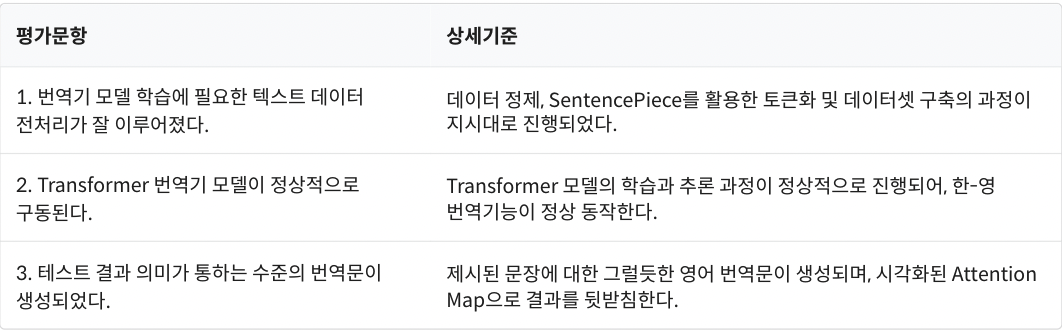

In [2]:
import tensorflow as tf
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import time
import re
import os
import io
from konlpy.tag import Mecab
from tqdm import tqdm_notebook,tqdm
import random

## DATA_LOAD ~ TOKENIZE

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = set(list(zip(kor,eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
n = 0
for i in cleaned_corpus:
    print(i[0])
    n +=1 
    if n == 5:
        break

이에 대해 공화당 전국위원회(RNC)의 알렉스 코넨트 대변인은 클린턴이 퍼르레이어스와 크로커의 메시지에 귀를 기울이지 않고 있다고 비난했다.
베를린 장벽이 무너진 뒤 18년이 지났어도 영화‘타인의 삶’은 동독 비밀경찰의 실체를 파해쳐 영화 평론가에게 주목을 받고 있다.
그는 간단히 아기 감시용 '베이비 모니터'만 켜면 된다.
반세기가 넘는 세월 만에 첫 정기 화물 운송이 화요일 남북한 간의 철통 같은 국경을 통과하여 운영되기 시작했다.
양당으로 나눠진 타이완 의회는 몸싸움도 서슴지 않는다.


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #모든 입력을 소문자로 변환합니다. + 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-z?.!,]+", " ", sentence)#알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [6]:
def preprocessing(cleaned_corpus):
    kor_corpus = []
    eng_corpus = []
    for sentence in cleaned_corpus:
        sentence_ko = preprocess_sentence(sentence[0])
        sentence_en = preprocess_sentence(sentence[1])
        kor_corpus.append(sentence_ko)
        eng_corpus.append(sentence_en)
    
    return kor_corpus, eng_corpus

kor_corpus, eng_corpus = preprocessing(cleaned_corpus)

In [7]:
len(kor_corpus),len(eng_corpus)

(78968, 78968)

In [8]:
#sentencepiece에 적용하기 위한 txt파일 생성

with open('kor.txt', 'w') as f:
    for sentence in kor_corpus:
        f.write('{}\n'.format(sentence))
with open('eng.txt', 'w') as f:
    for sentence in eng_corpus:
        f.write('{}\n'.format(sentence))

In [9]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,vocab_size,lang="ko",pad_id=0,bos_id=1,eos_id=2,unk_id=3):
    prefix = 'GD_10_'+lang
    spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size} \
        --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} \
        --character_coverage={1.0} --model_type=unigram"
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(prefix+'.model')
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer('kor.txt', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer('eng.txt', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos") # 문장 양끝에 <s></s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=kor.txt --model_prefix=GD_10_ko --vocab_size=20000         --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3         --character_coverage=1.0 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: kor.txt
  input_format: 
  model_prefix: GD_10_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  e

True

In [10]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
        
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:04<00:00, 16902.71it/s]


In [11]:
enc_train.shape,dec_train.shape

((72124, 50), (72124, 50))

In [12]:
with open('./GD_10_ko.vocab', encoding='utf-8') as f:
    Vo_k = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
kor_word2idx = {w[0]: i for i, w in enumerate(Vo_k)}
with open('./GD_10_en.vocab', encoding='utf-8') as f:
    Vo_e = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
eng_word2idx = {w[0]: i for i, w in enumerate(Vo_e)}
VOCAB_SIZE = len(kor_word2idx)
len(eng_word2idx)

20000

## Model

In [13]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q,K,transpose_b=True)

        scaled_qk = QK/tf.math.sqrt(d_k)

        """
        Scaled QK 값 구하기
        """

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk,axis=-1)
        out = tf.matmul(attentions,V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
        split_x = tf.transpose(split_x,perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x,perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x,(batch_size,-1,self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out,attention_weights = self.scaled_dot_product_attention(WQ_splits,WK_splits,WV_splits,mask)
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [15]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,d_ff,dropout):
        super(DecoderLayer,self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model,num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model,num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model,d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self,x,enc_out,causality_mask,padding_mask):
        residual = x
        out = self.norm_1(x)
        out,dec_attn = self.dec_self_attn(out,out,out,padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out 
        out = self.norm_2(out)
        out,dec_enc_attn = self.enc_dec_attn(out,enc_out,enc_out,causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out,dec_attn,dec_enc_attn

In [18]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # tf.math.equal 동일한 위치 값이 같으면 TRUE
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    '''
    np.eye = identity matrix (src_len * tgt_len)
    np.cumsum(np.eye(),0) axis=0은 열기준 누적합 -> 원소 값이 1인 삼각형 행렬 생성
    '''
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0) # 1 - 로 인해서 마스크 뒤집힘
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask) # 동일 위치 최대값 리턴

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
    
    
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [20]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size,d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size,d_model)

        self.pos_encoding = positional_encoding(pos_len,d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers,d_model,n_heads,d_ff,dropout)
        self.decoder = Decoder(n_layers,d_model,n_heads,d_ff,dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:,:seq_len,:]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb,enc_in)
        dec_in = self.embedding(self.dec_emb,dec_in)

        enc_out,enc_attns = self.encoder(enc_in,enc_mask)

        dec_out,dec_attns,dec_enc_attns = \
        self.decoder(dec_in,enc_out,causality_mask,dec_mask)

        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [21]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## Loss function / train_step define

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [23]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [24]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [25]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [26]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## TRAIN / INFERENCE

In [27]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared=True)

d_model = 512

In [28]:
BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_32/1709978226.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a obama s president barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new york are in the world .
Input: 커피는 필요 없다.
Predicted translation: the facts , or not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were killed in the capital , the capital , the capital , the death of the capital , the death toll in the capital , the capital , the capital , the ministry said .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were among the dead wednesday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president elect barack obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a mountain of city .
Input: 커피는 필요 없다.
Predicted translation: no coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were among the dead .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city of new york city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is no longer need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they want to eat .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people died sunday , the official said .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are then eager to get to safe .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people died sunday when the ap reported seven death toll was killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is increasingly sitting in his country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is a town for .
Input: 커피는 필요 없다.
Predicted translation: the coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed tuesday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big bang .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will get a common version of the city .
Input: 커피는 필요 없다.
Predicted translation: we need to make coffee customers .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the last sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his own .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town then is fine , for a third .
Input: 커피는 필요 없다.
Predicted translation: we need to pay for the cat there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were among the dead .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a little more than a trillion .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city hall will fall in town on for more than , city .
Input: 커피는 필요 없다.
Predicted translation: we need to do cup .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were among the dead .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will then remember the city s violent cities .
Input: 커피는 필요 없다.
Predicted translation: he needs good for battleground .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six others died were in the catastrophe .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city s old .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people died tuesday in wounds from wounds .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will then remember all the city s software .
Input: 커피는 필요 없다.
Predicted translation: the coffee is fair .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were killed , with no deaths .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is eyed thankss to his own policies .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will continue .
Input: 커피는 필요 없다.
Predicted translation: the coffee is fair .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people died .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will be in the city .
Input: 커피는 필요 없다.
Predicted translation: we need for coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were killed in monday s catastrophic toll .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s the obama senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is only the city s rear my mountains .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six other people died , are over , met with seven other people .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is an obama spokesman .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will take it sometimes around the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is just need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the wednesday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his pickup .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will then live in in in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is called cup .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were injured tuesday , .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is ancoming president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will live in a mountainous region in the city .
Input: 커피는 필요 없다.
Predicted translation: there is just need for loan .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died when the seventhir blew away from seven people .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is an active presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they will then live in the city .
Input: 커피는 필요 없다.
Predicted translation: the need for called good money .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were injured tuesday , .


Input: 오바마는 대통령이다.
Predicted translation: obama is an active presidential candidate .
Encoder Layer 1


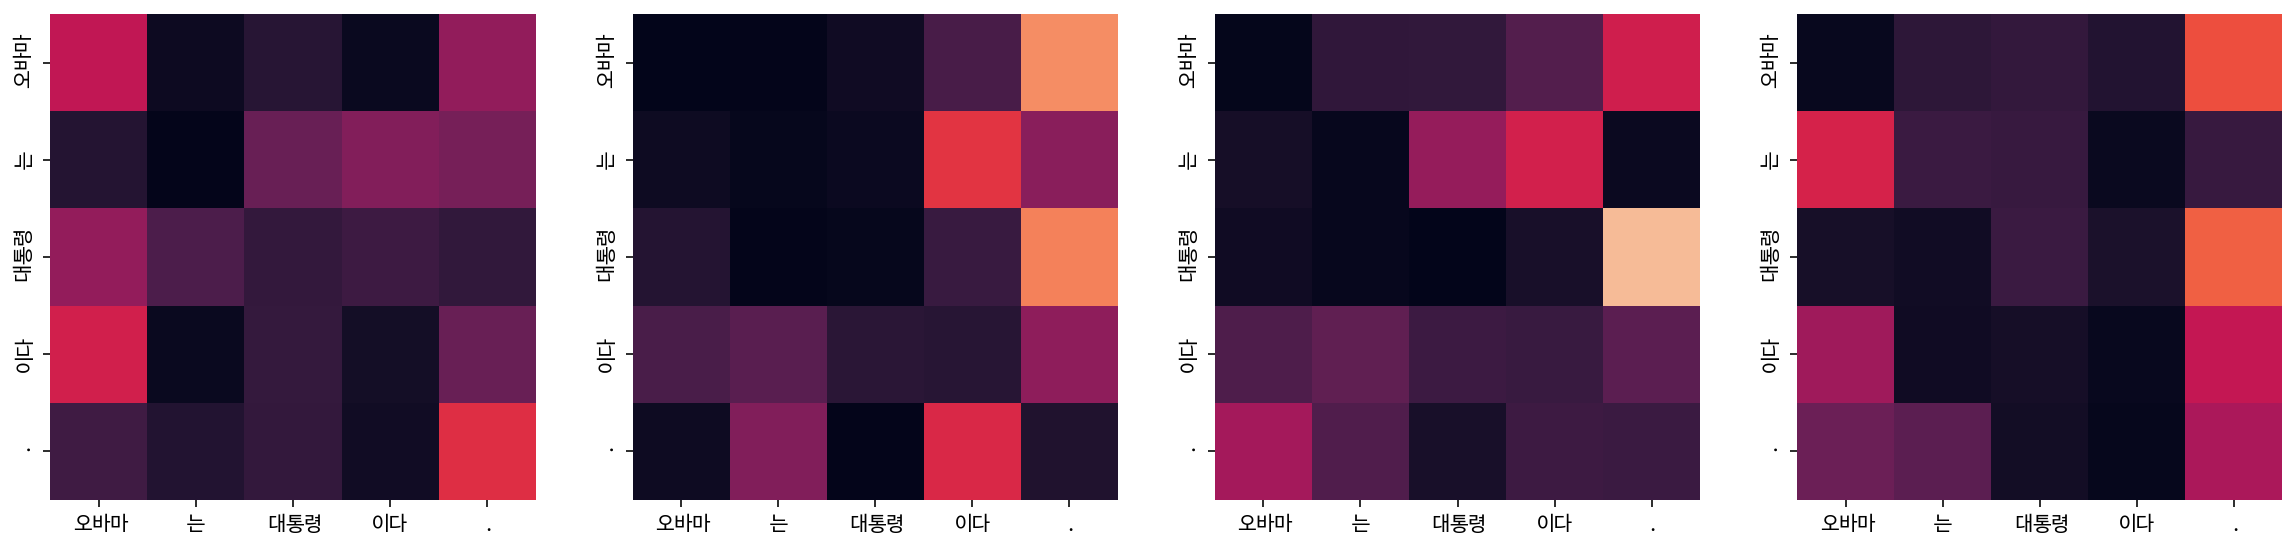

Encoder Layer 2


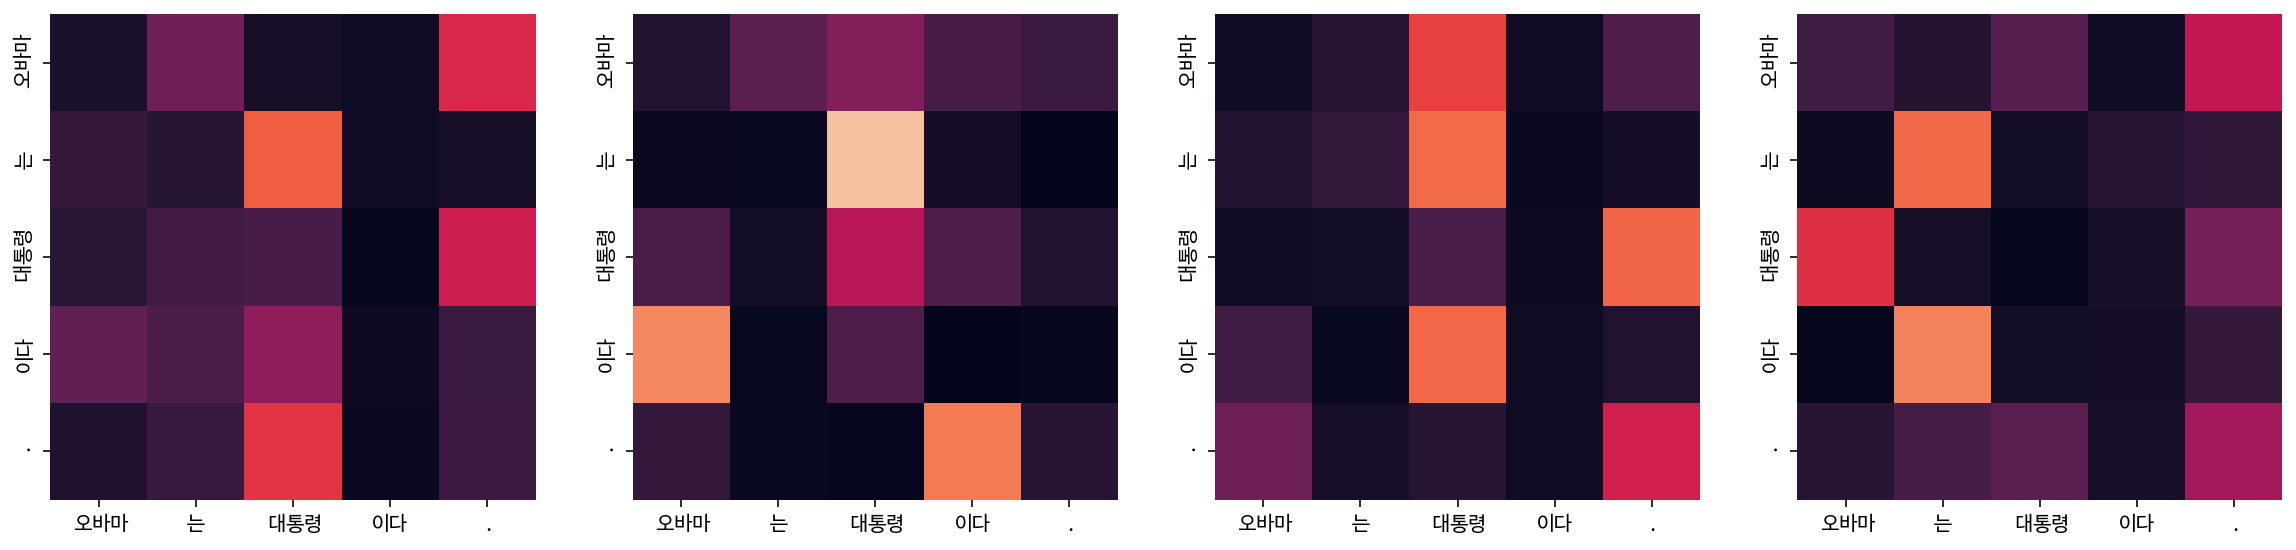

Decoder Self Layer 1


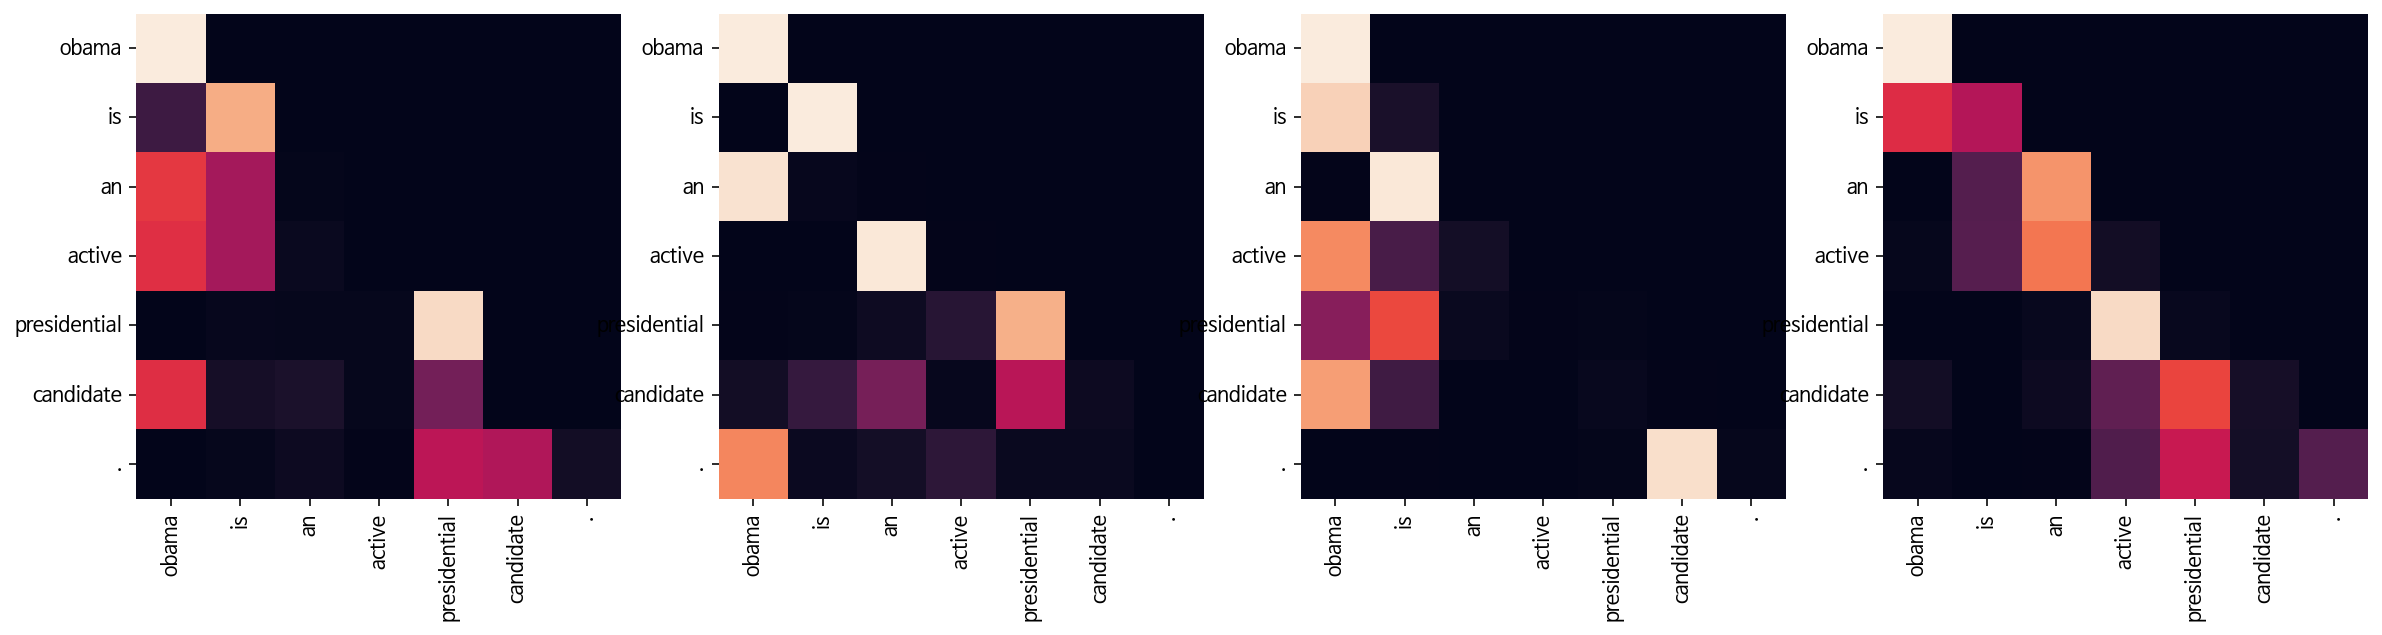

Decoder Src Layer 1


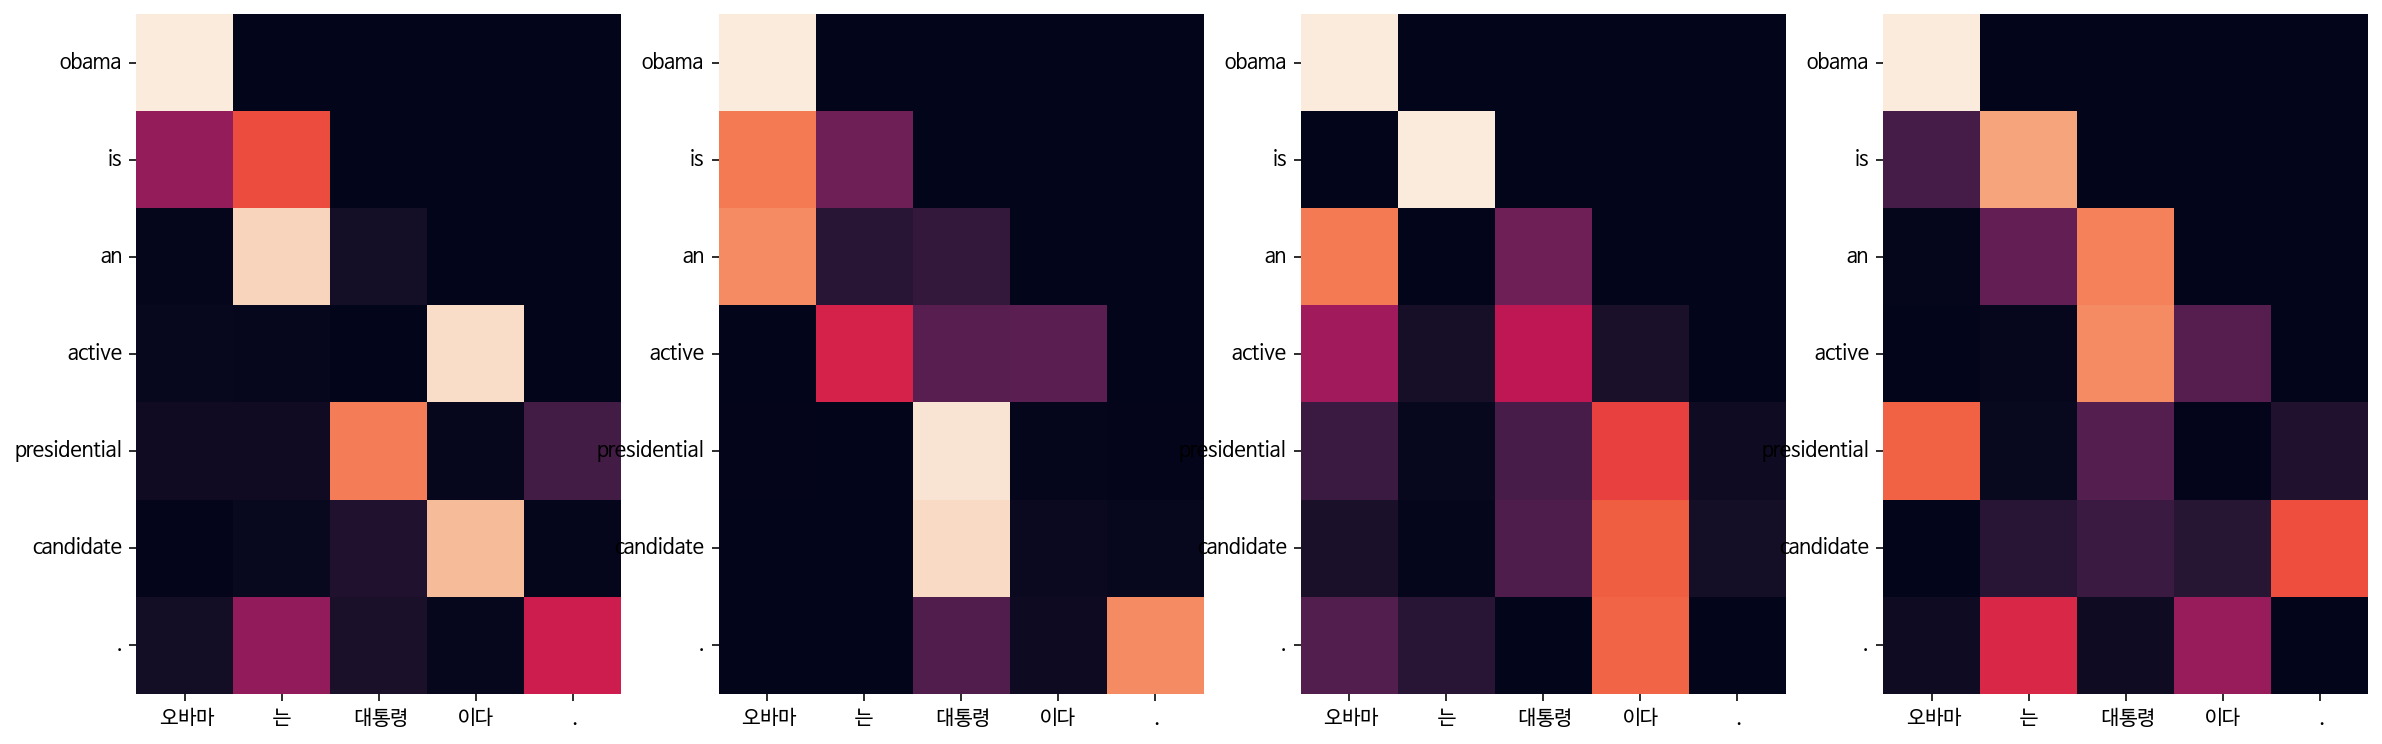

Decoder Self Layer 2


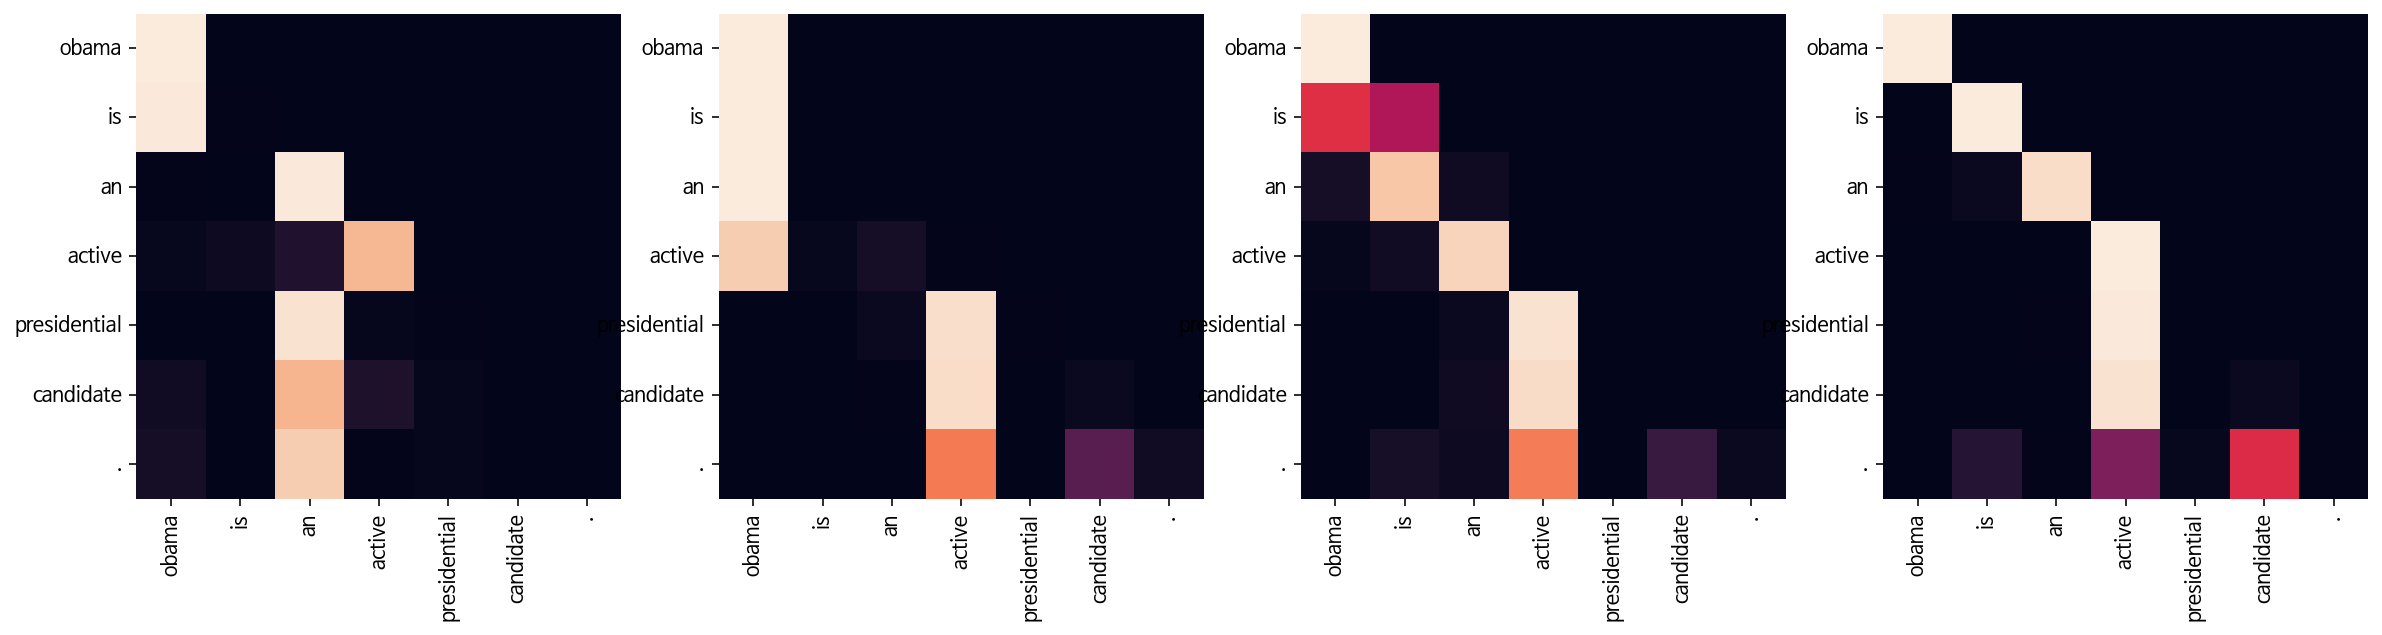

Decoder Src Layer 2


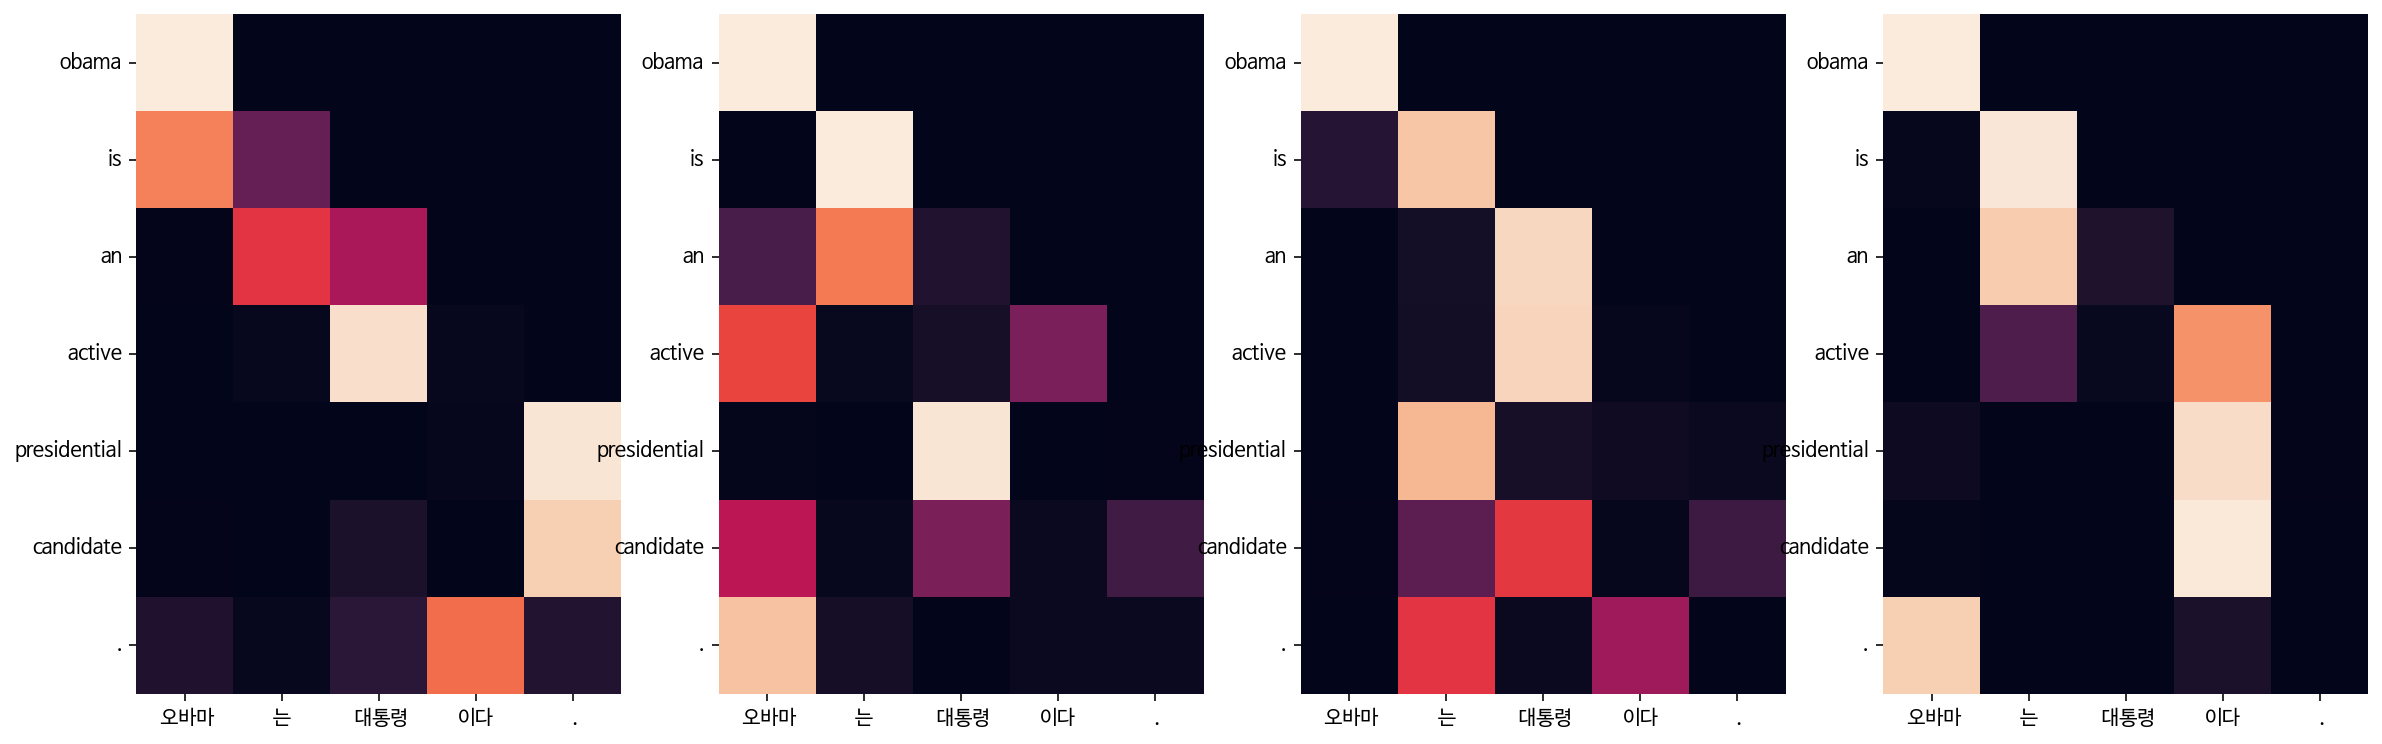

Input: 시민들은 도시 속에 산다.
Predicted translation: they will then live in the city .
Encoder Layer 1


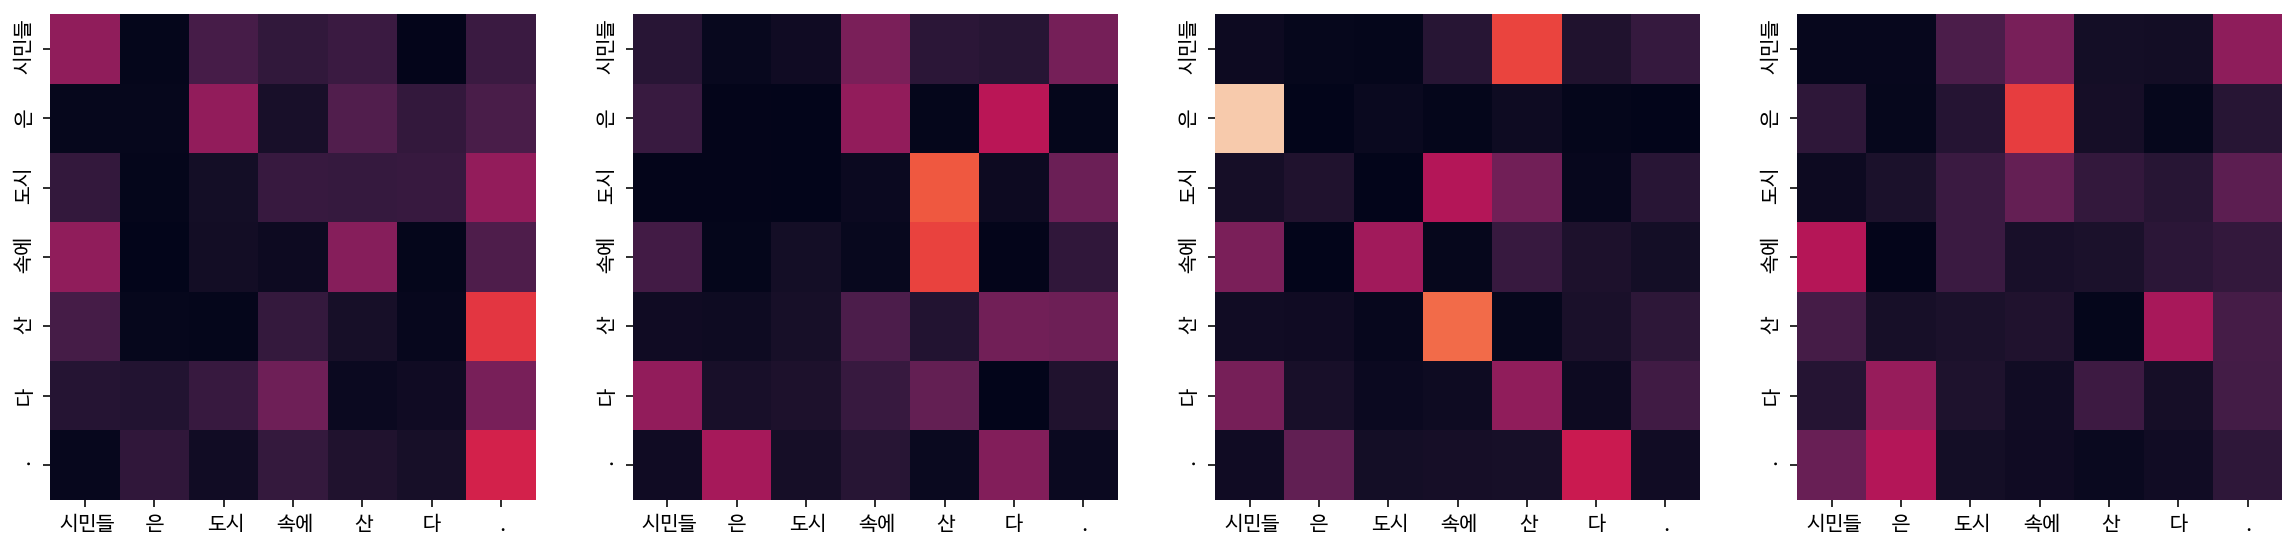

Encoder Layer 2


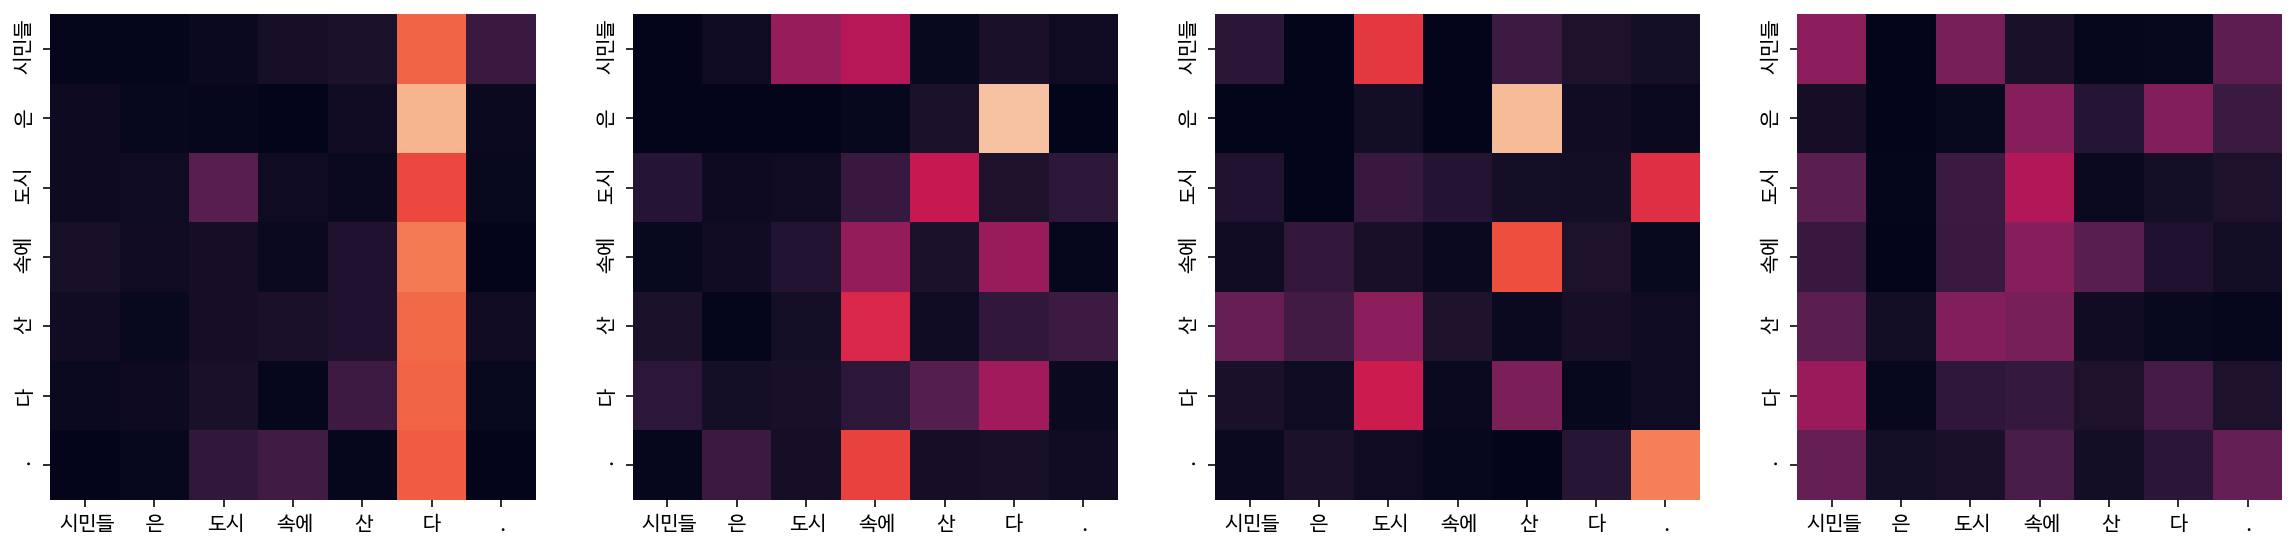

Decoder Self Layer 1


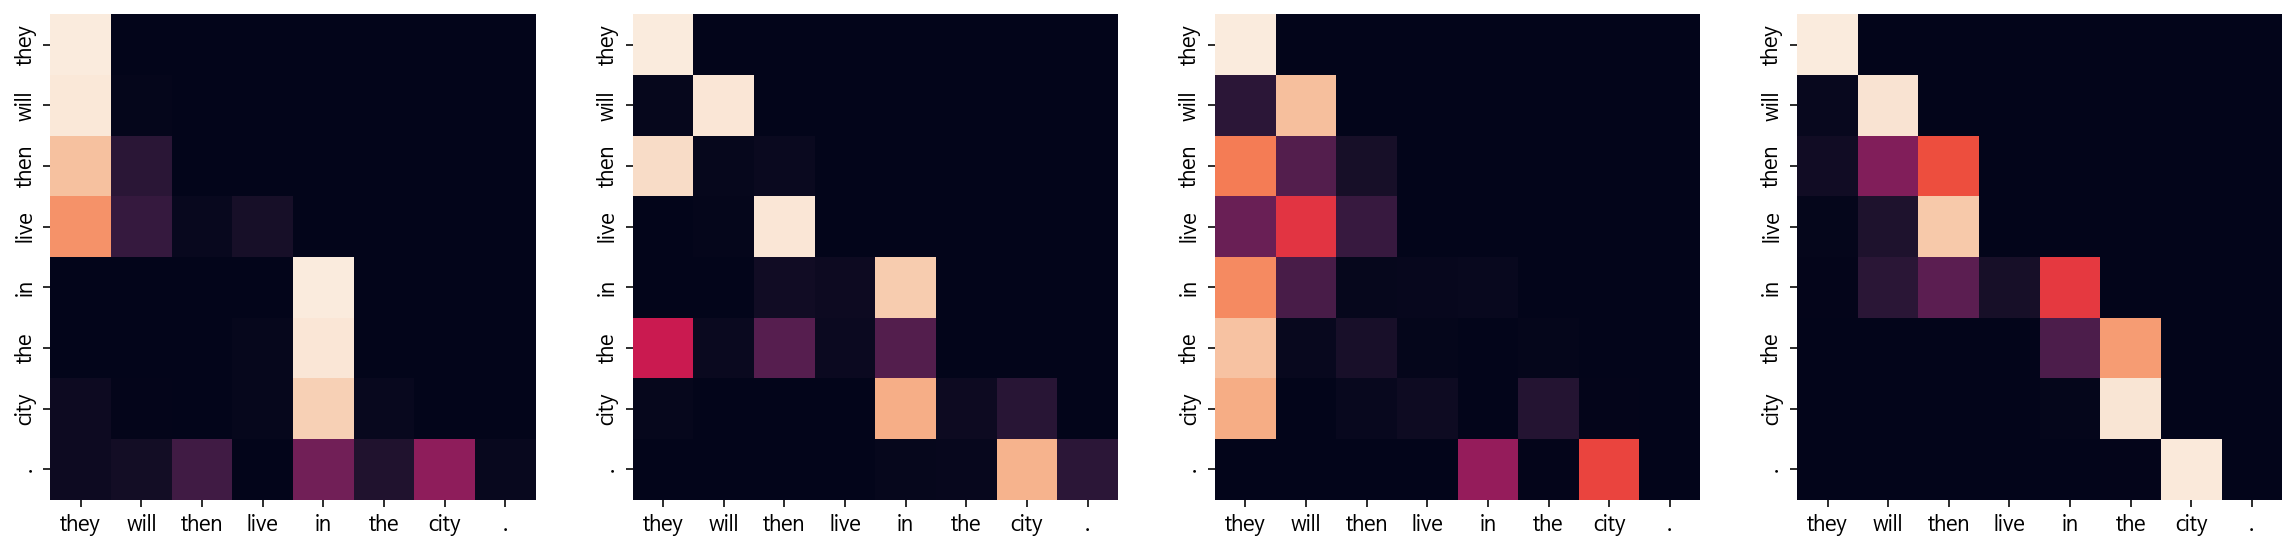

Decoder Src Layer 1


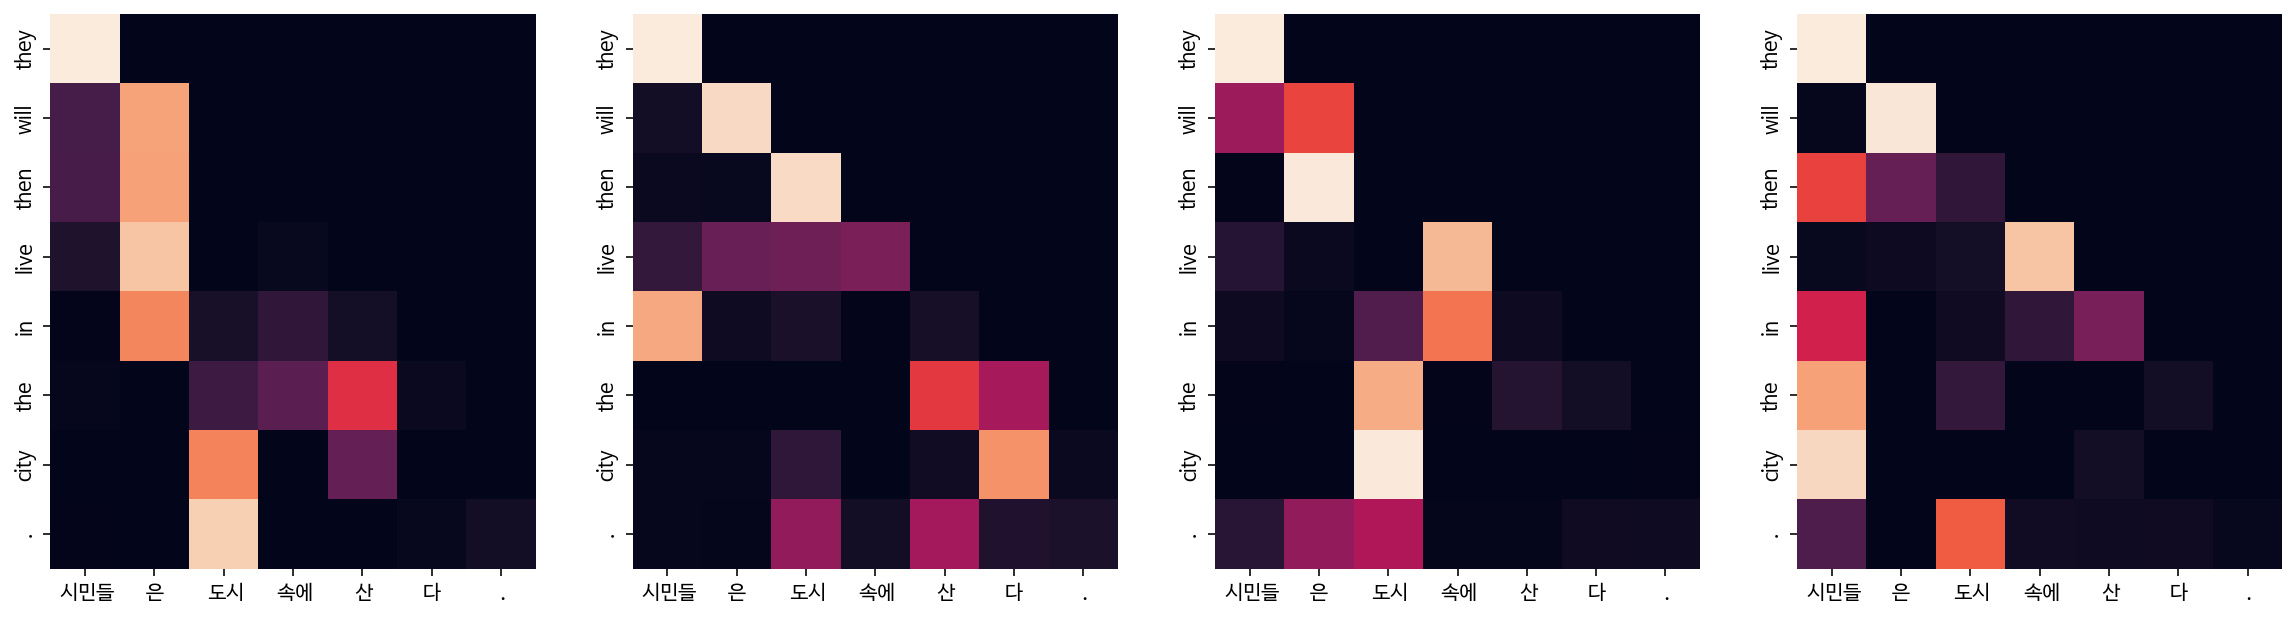

Decoder Self Layer 2


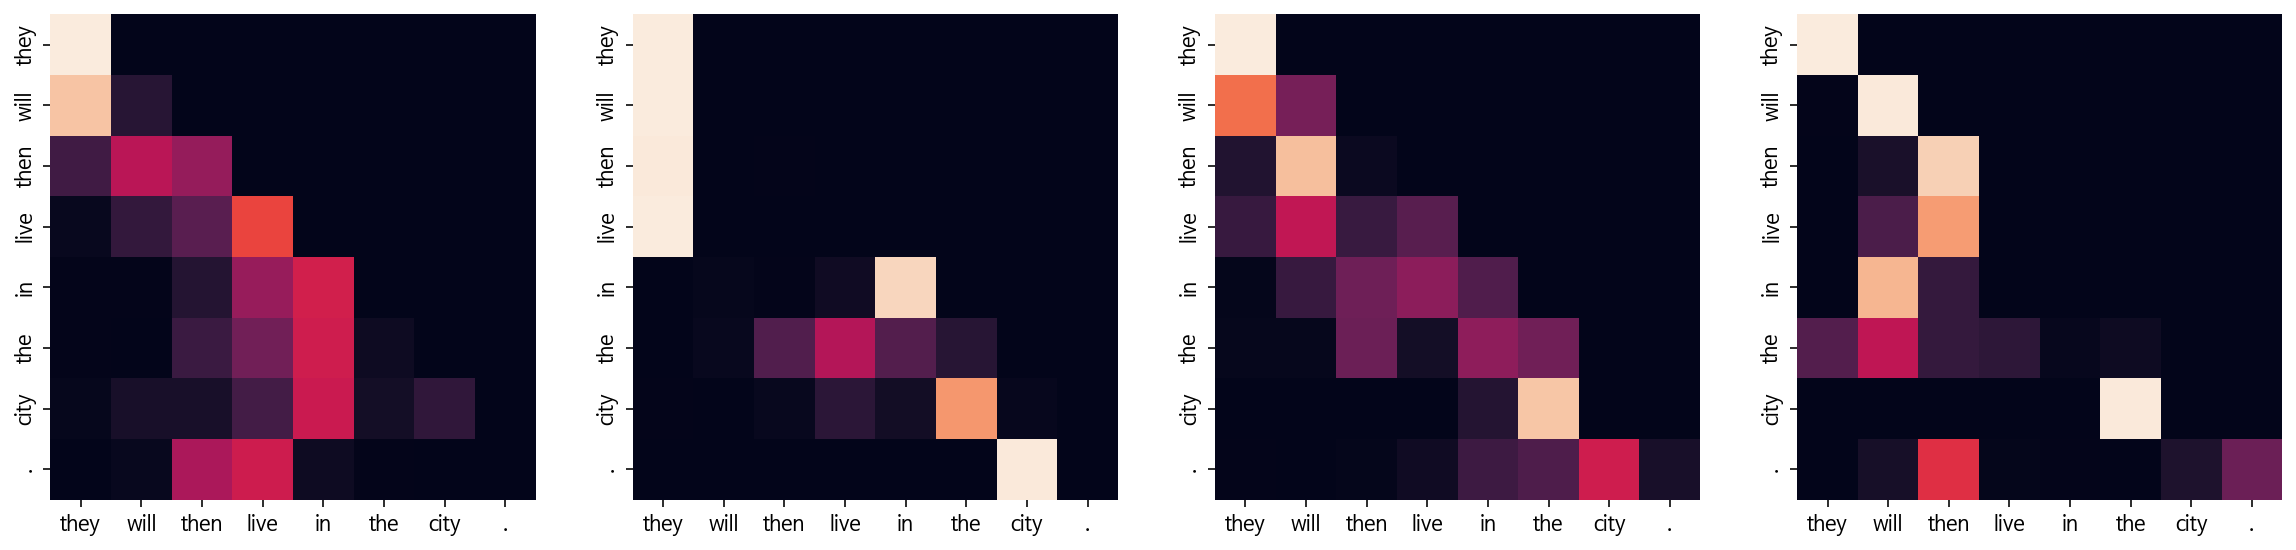

Decoder Src Layer 2


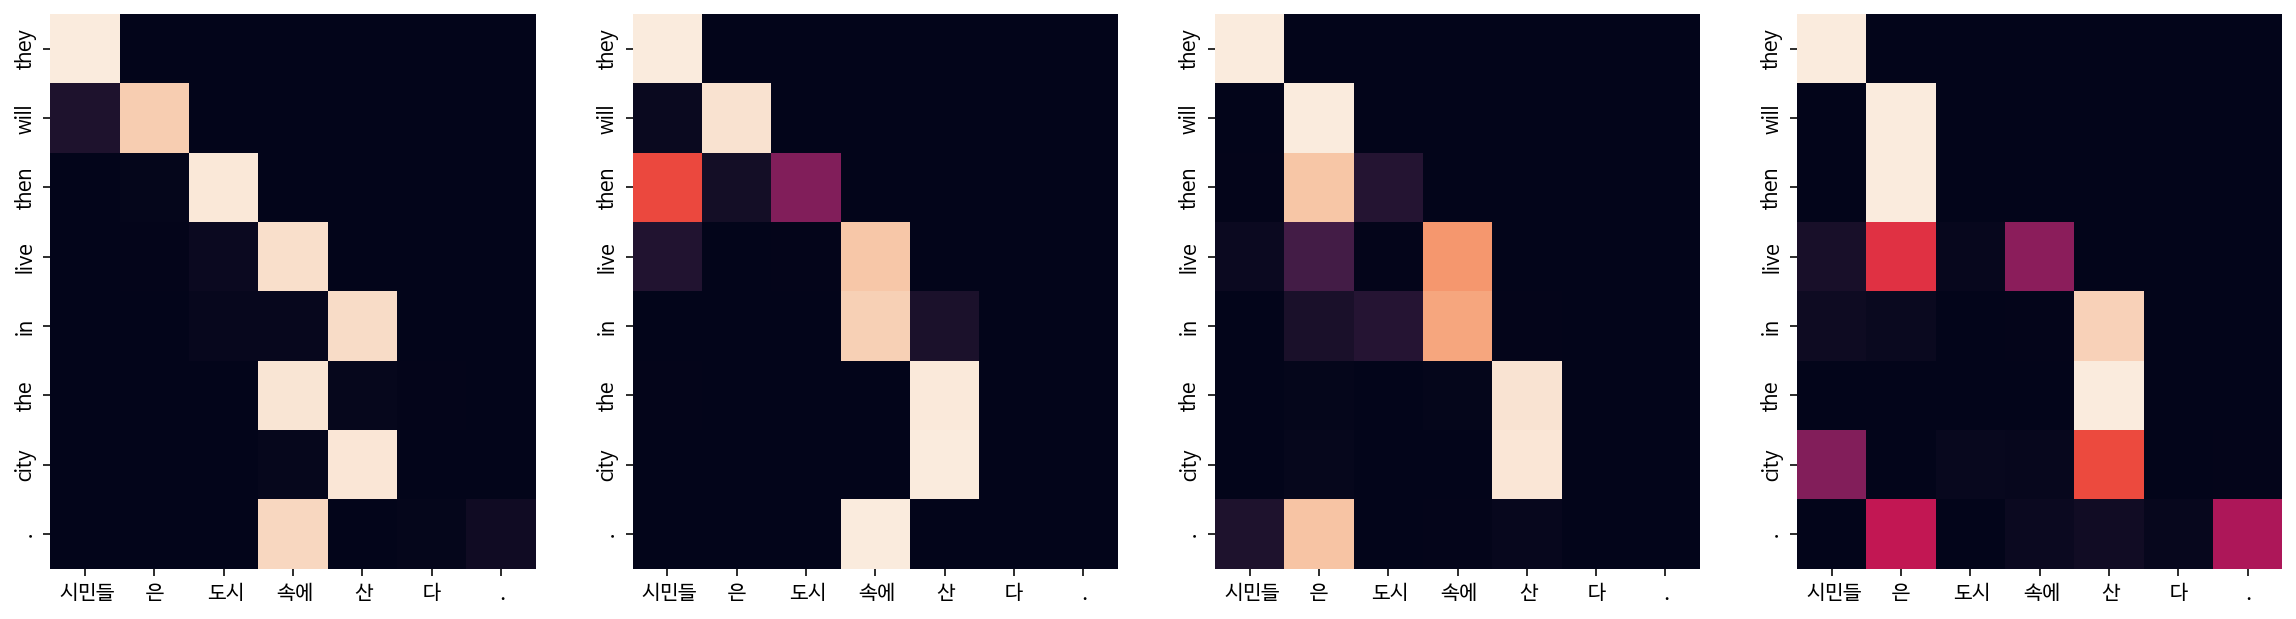

Input: 커피는 필요 없다.
Predicted translation: the need for called good money .
Encoder Layer 1


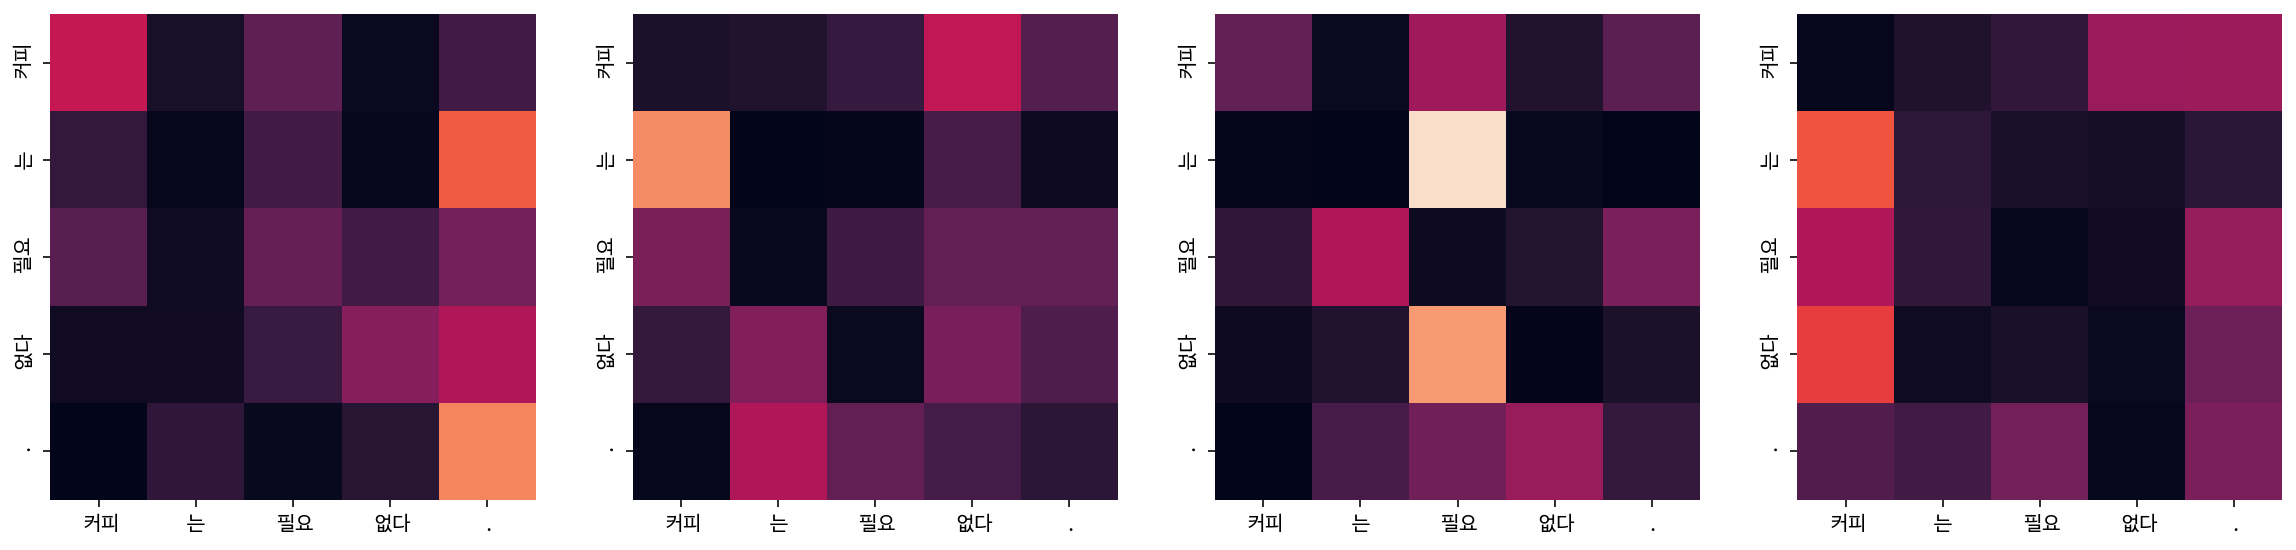

Encoder Layer 2


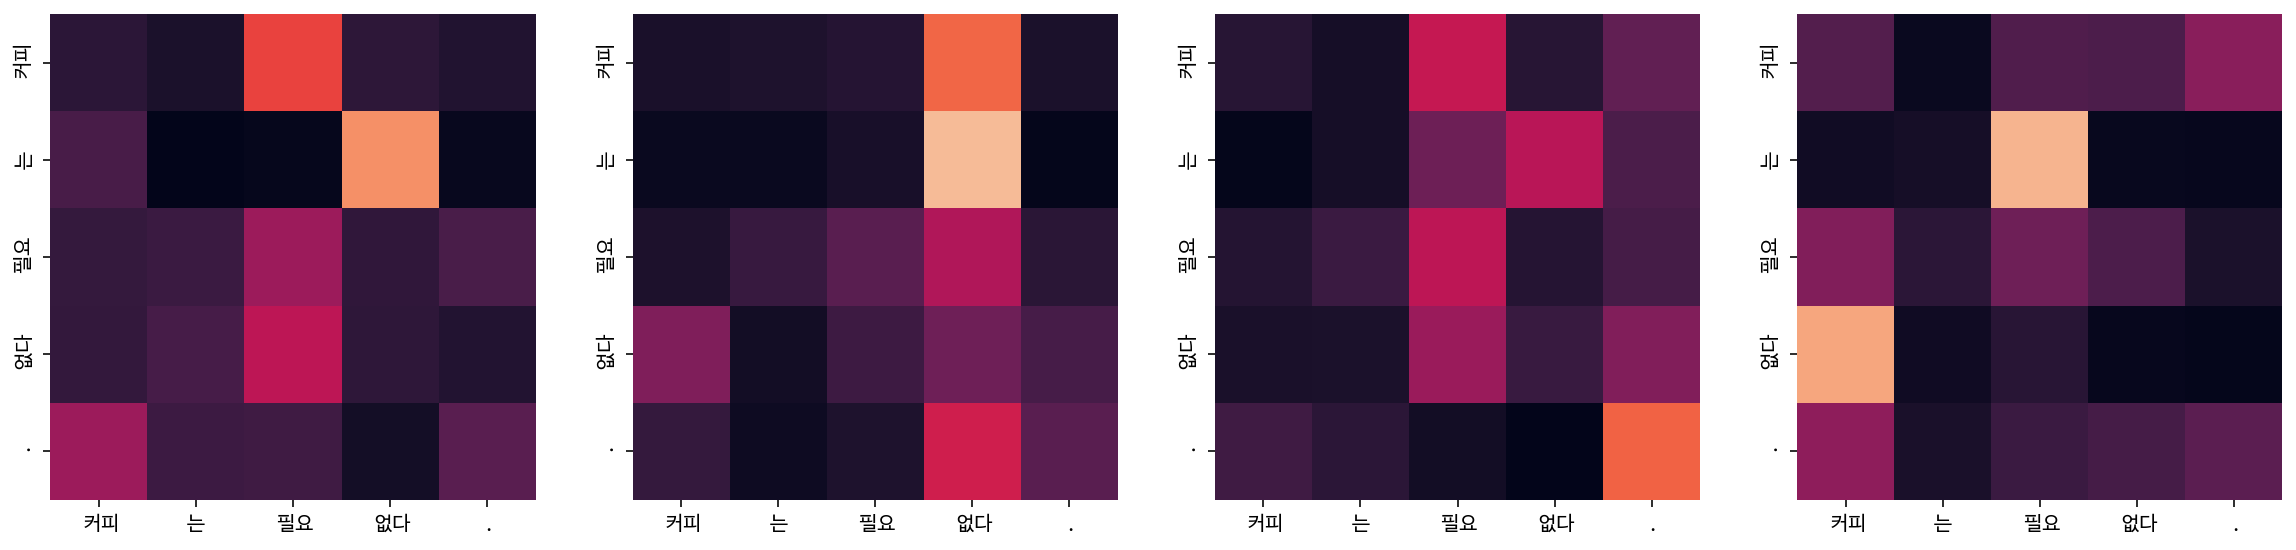

Decoder Self Layer 1


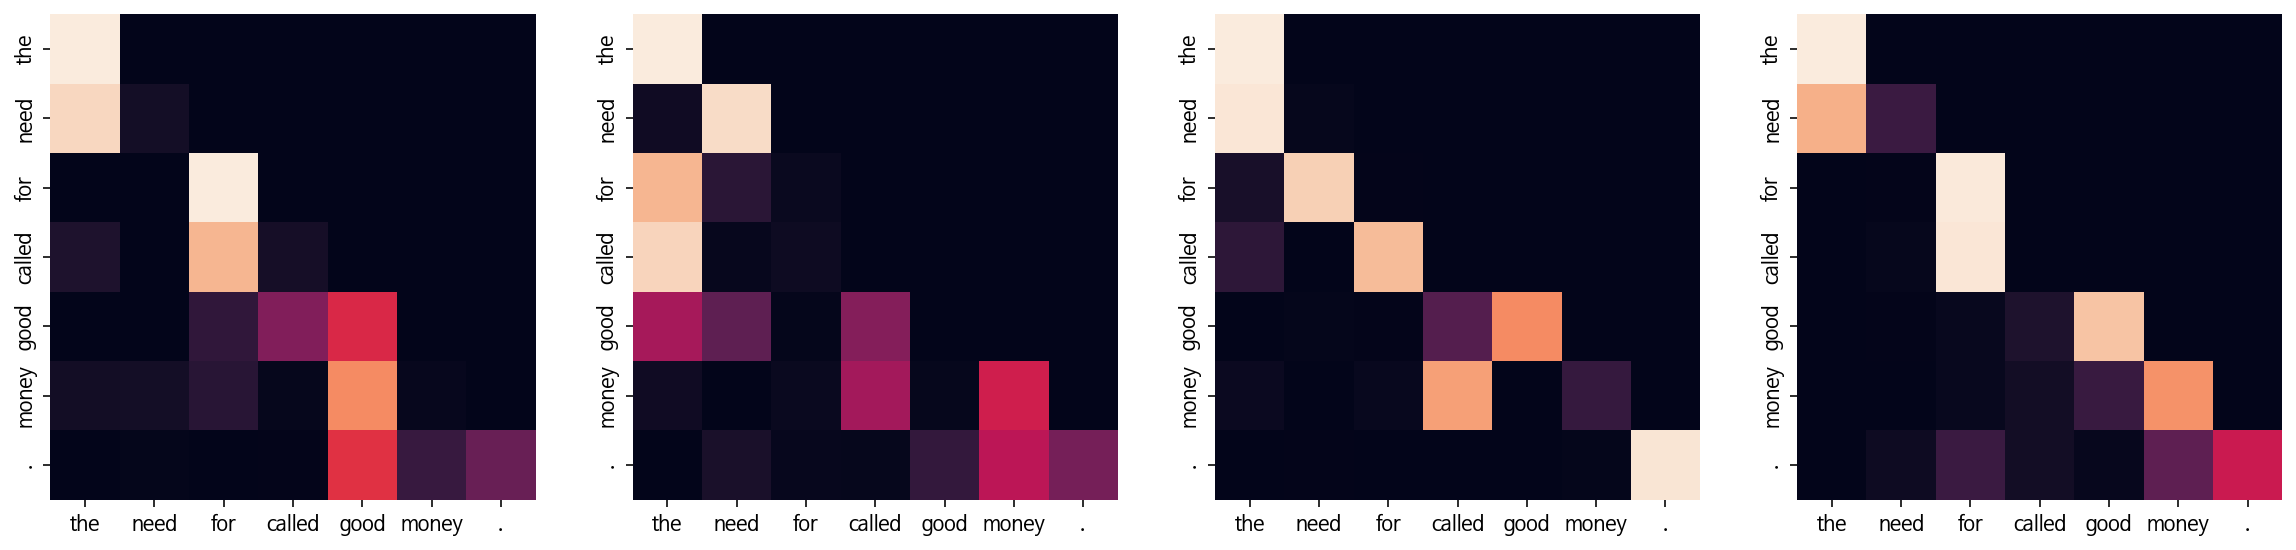

Decoder Src Layer 1


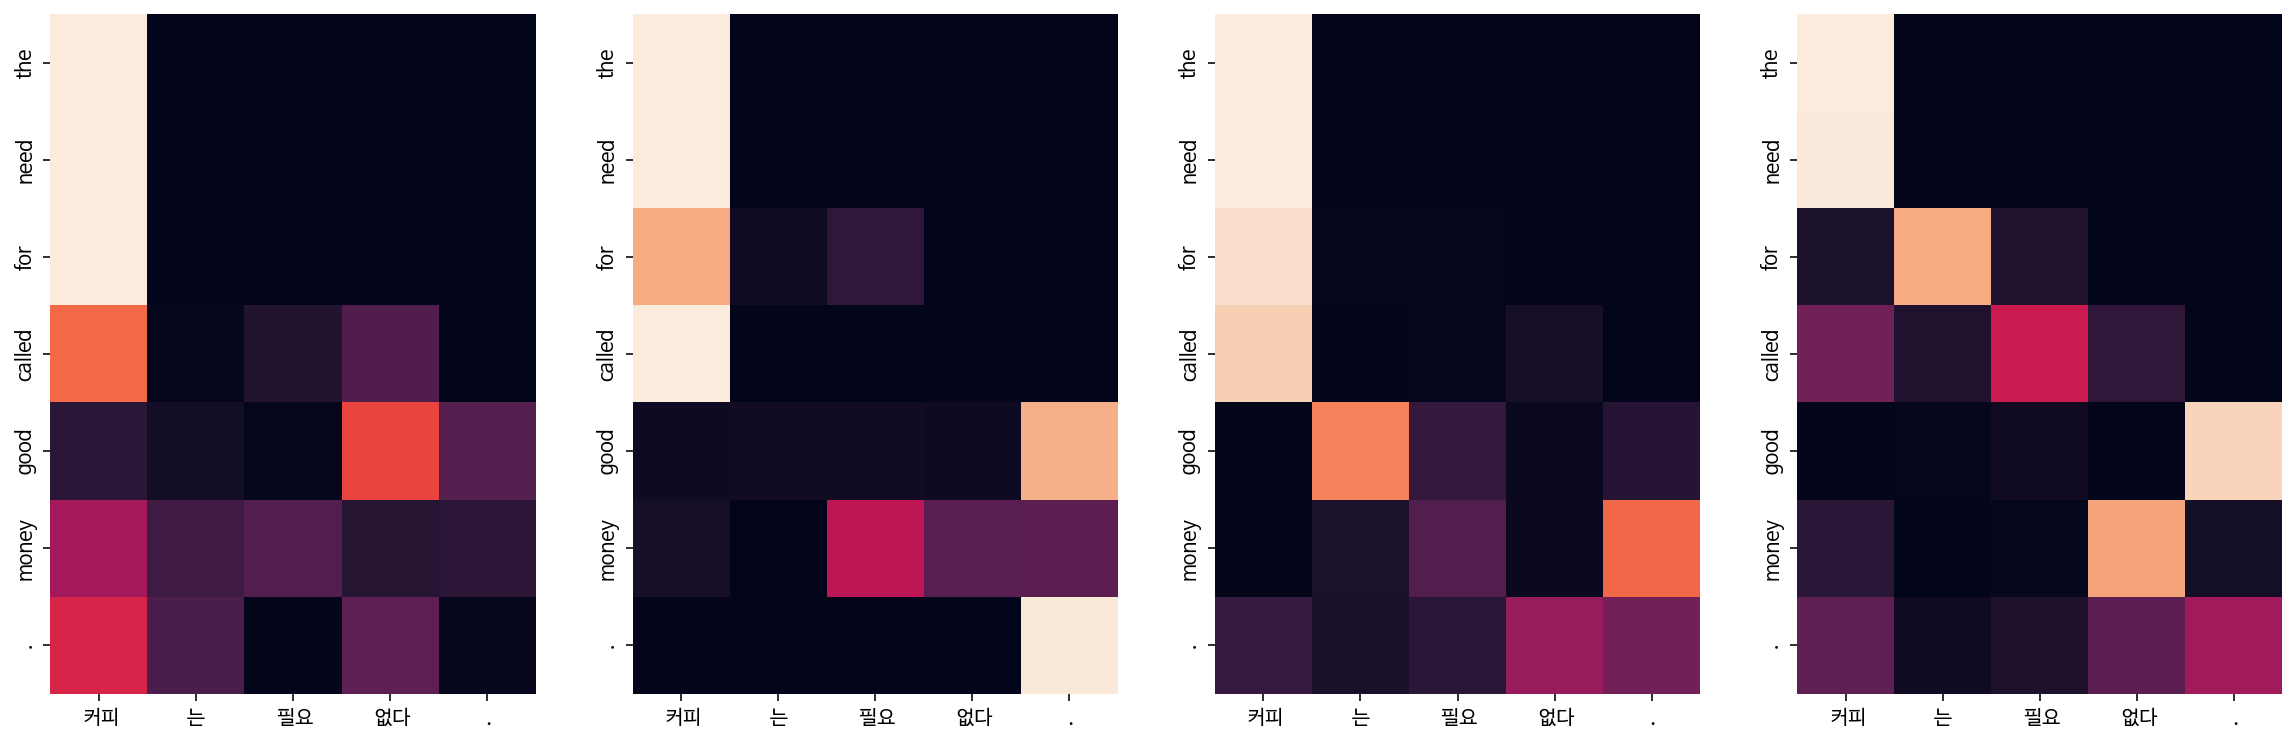

Decoder Self Layer 2


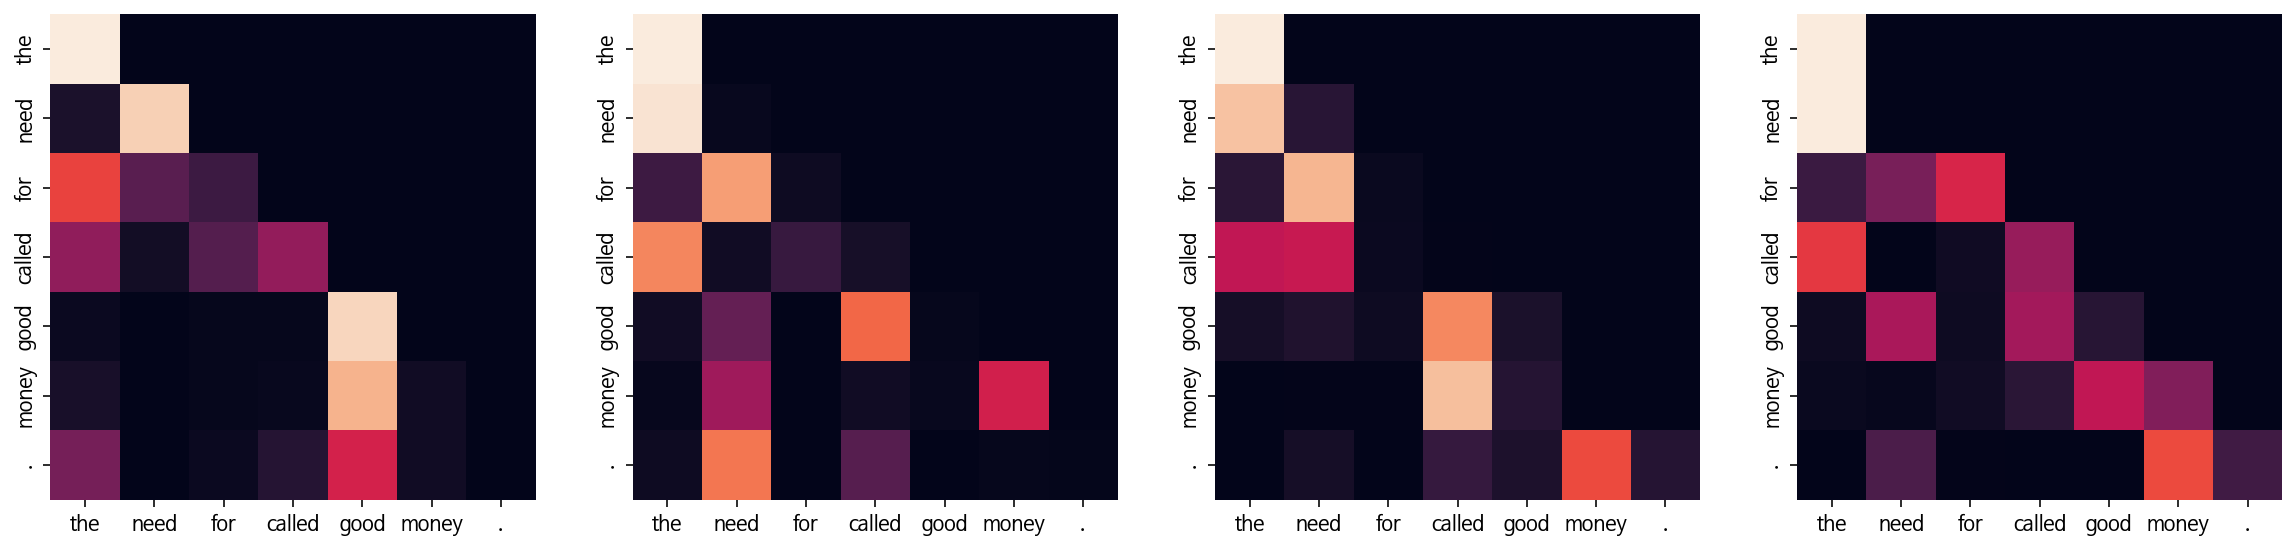

Decoder Src Layer 2


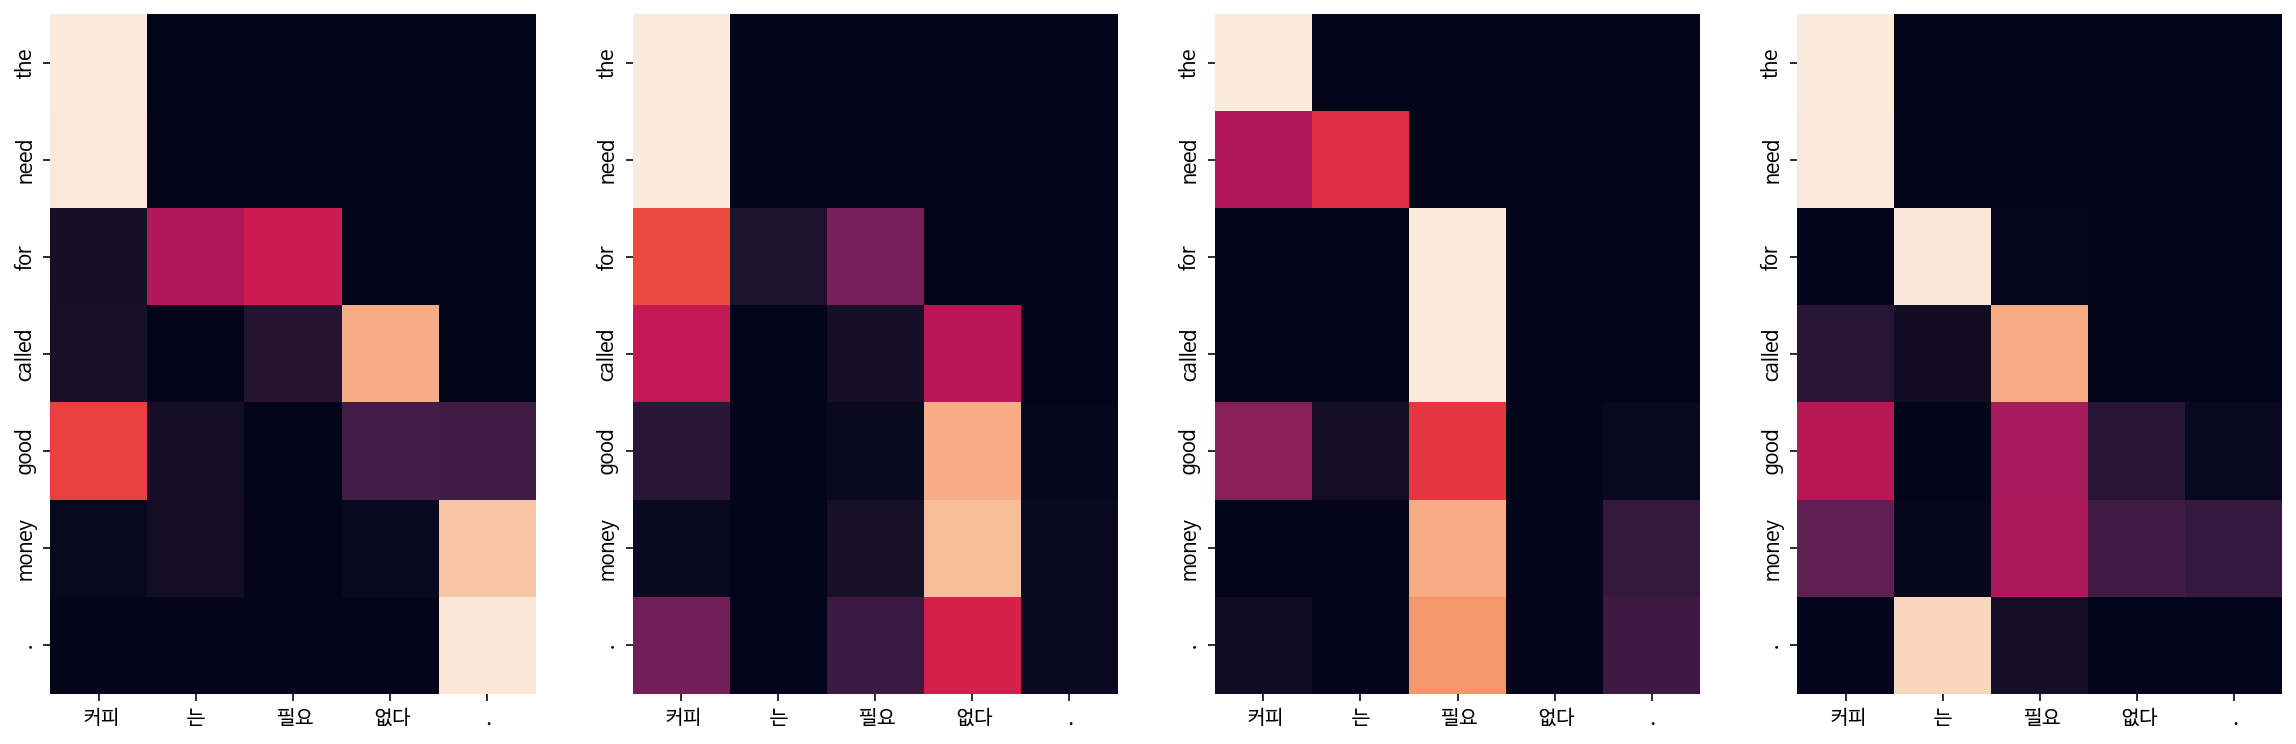

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were injured tuesday , .
Encoder Layer 1


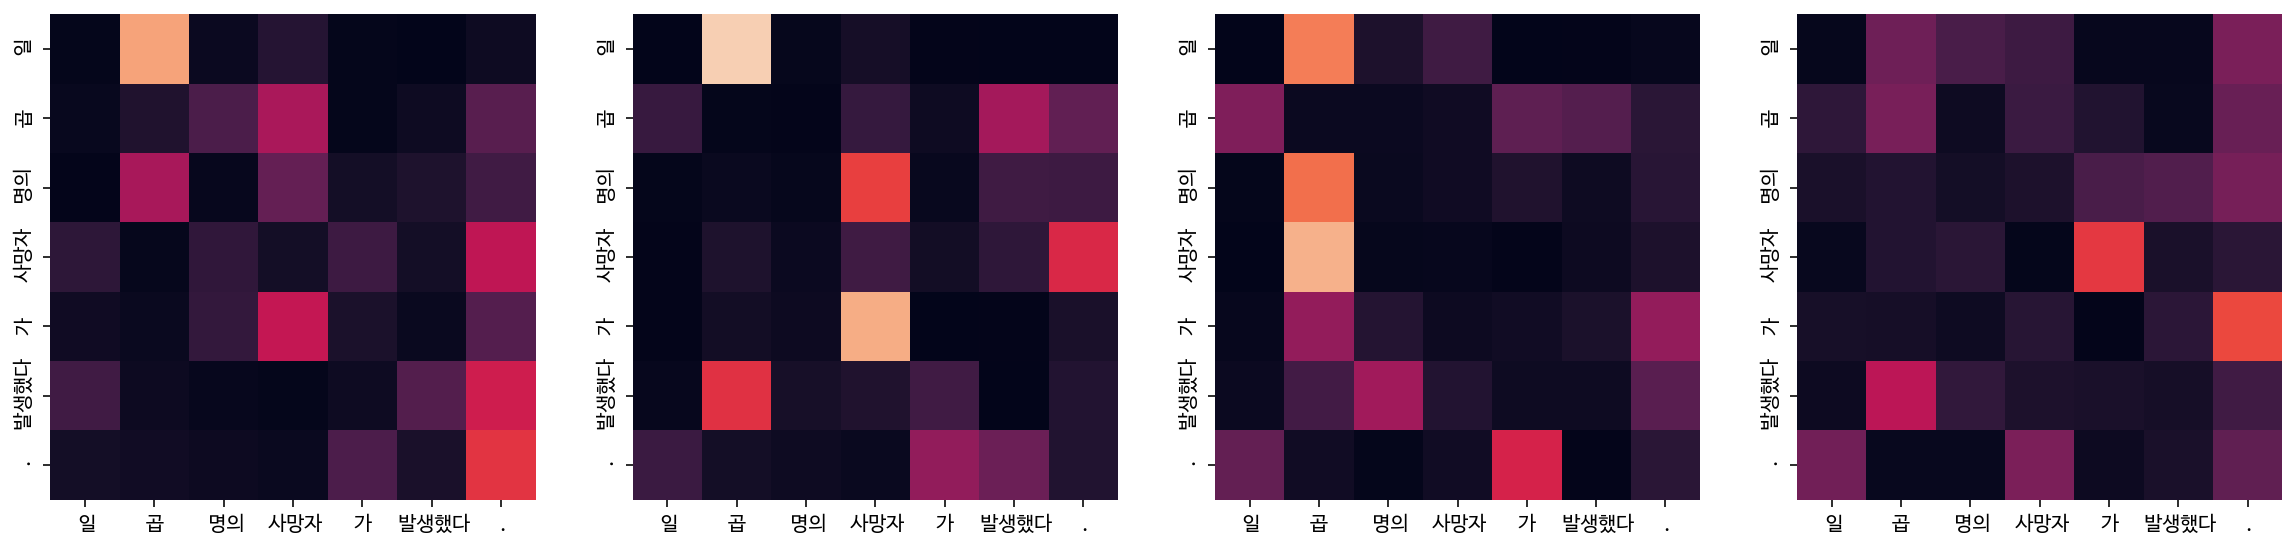

Encoder Layer 2


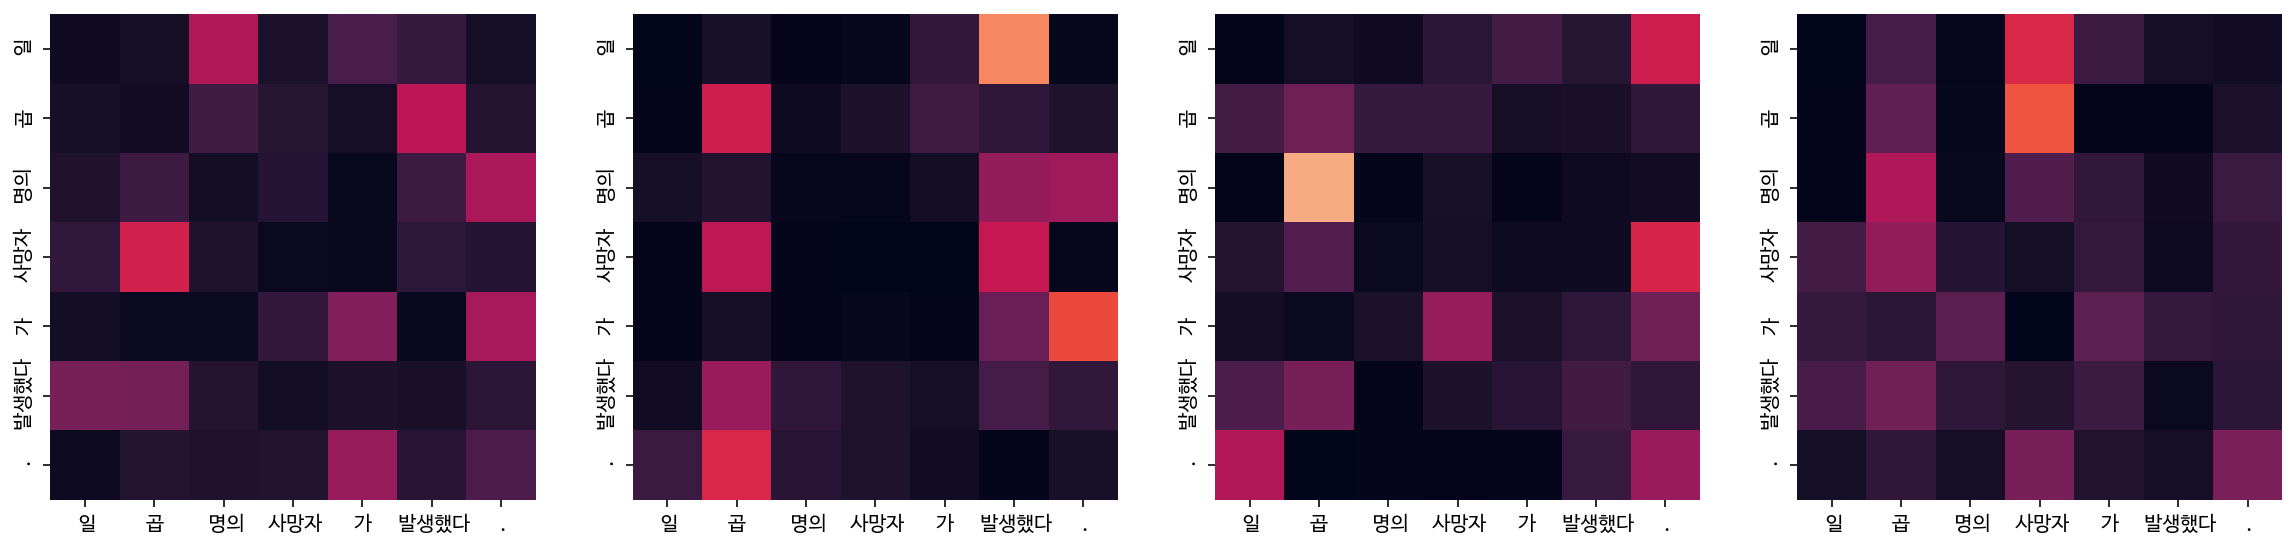

Decoder Self Layer 1


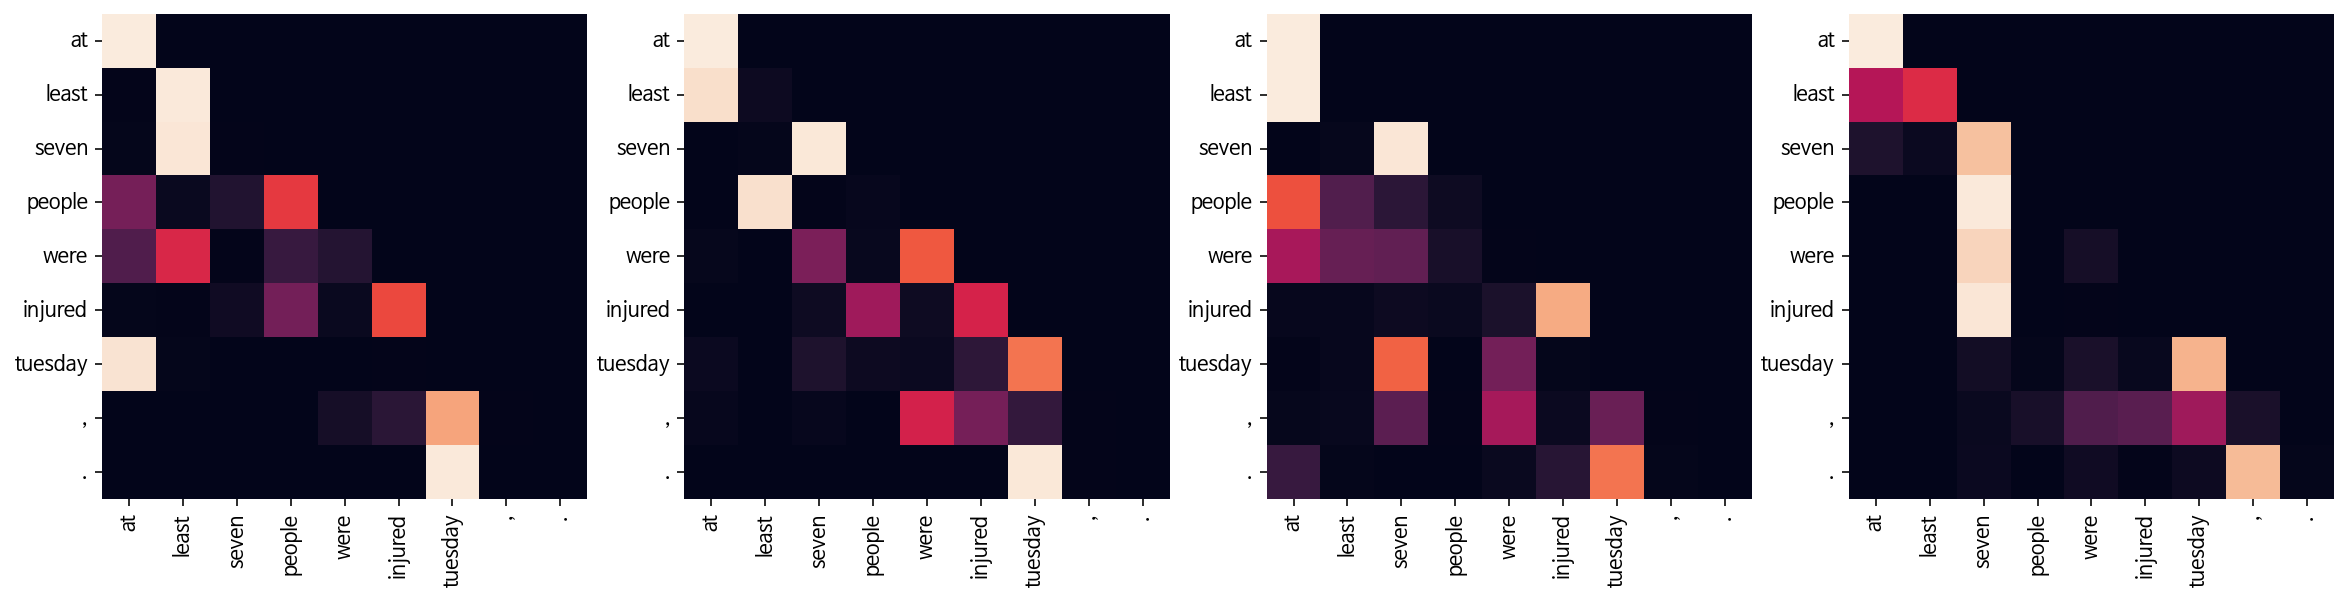

Decoder Src Layer 1


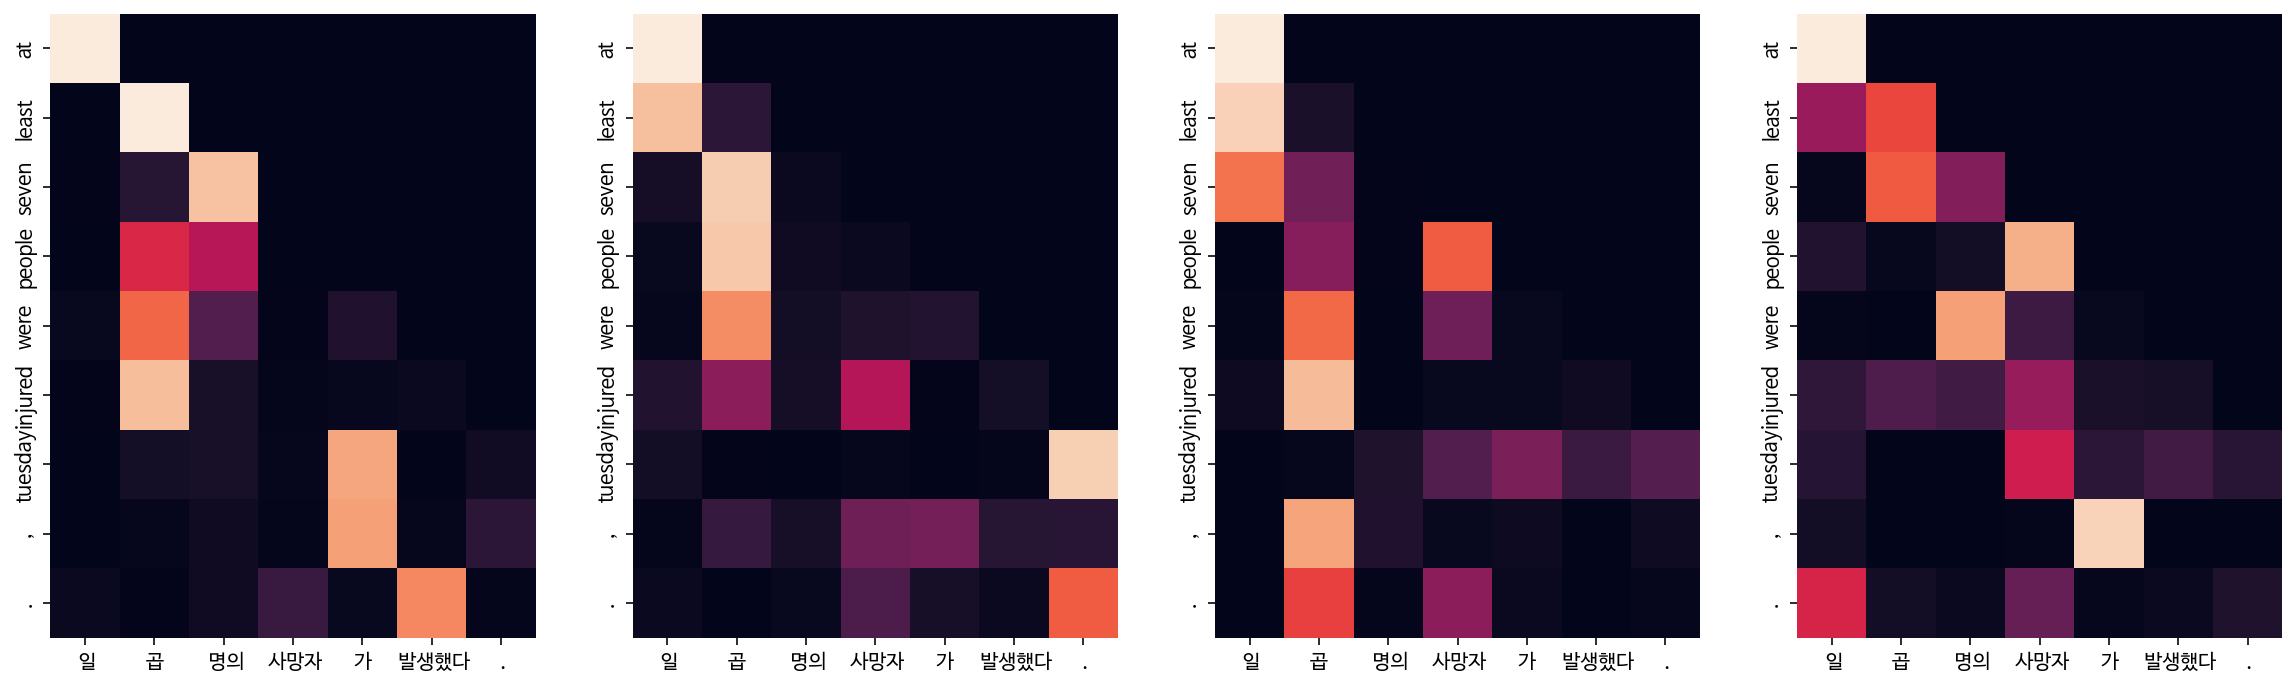

Decoder Self Layer 2


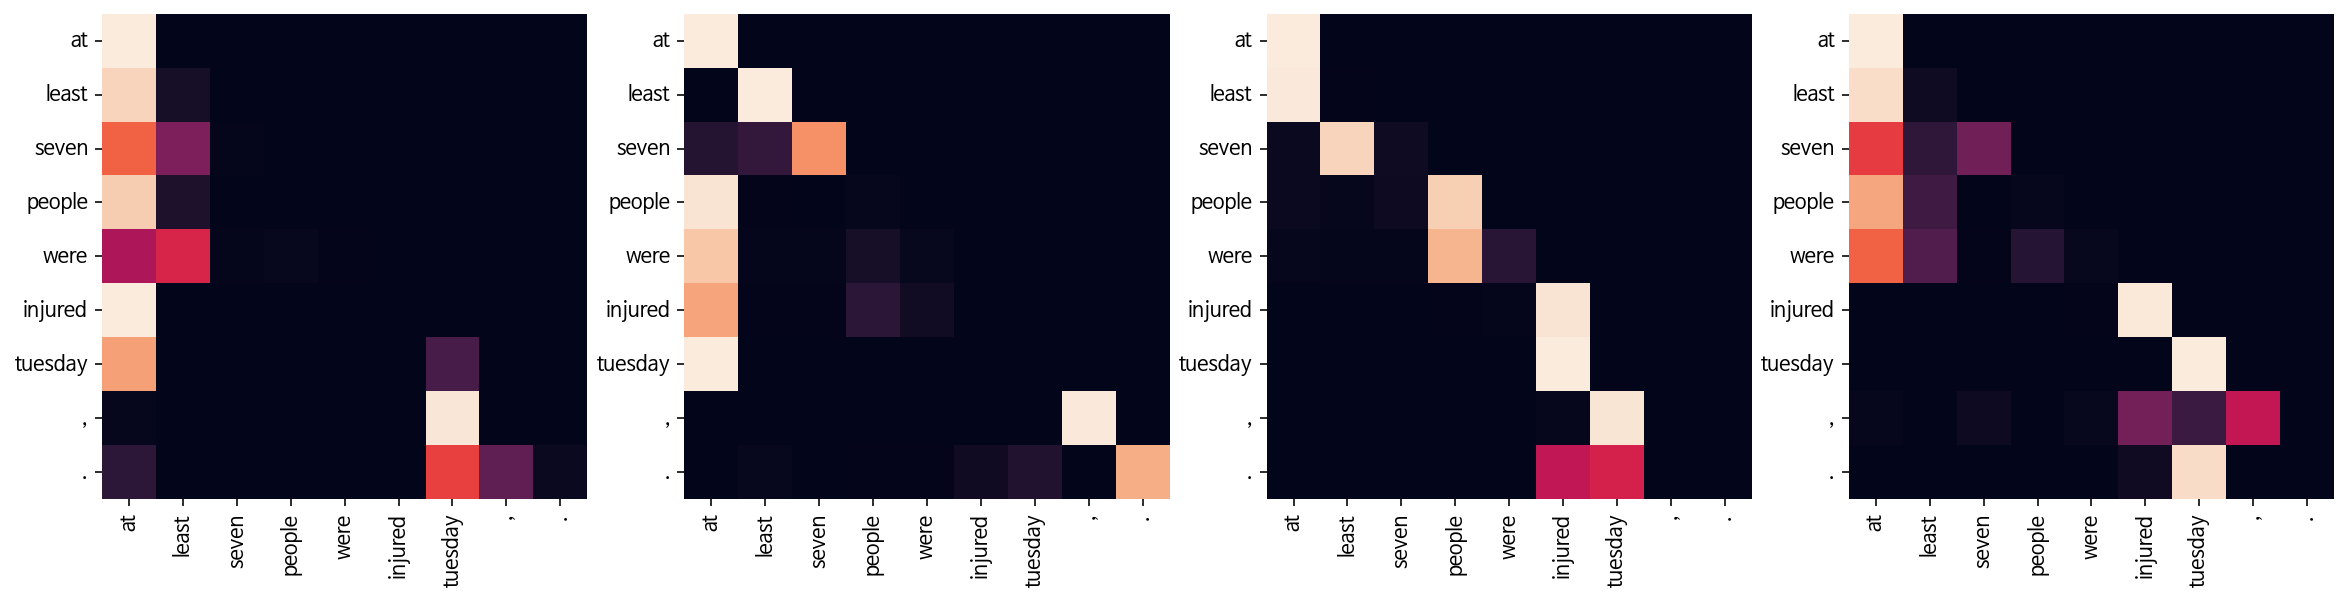

Decoder Src Layer 2


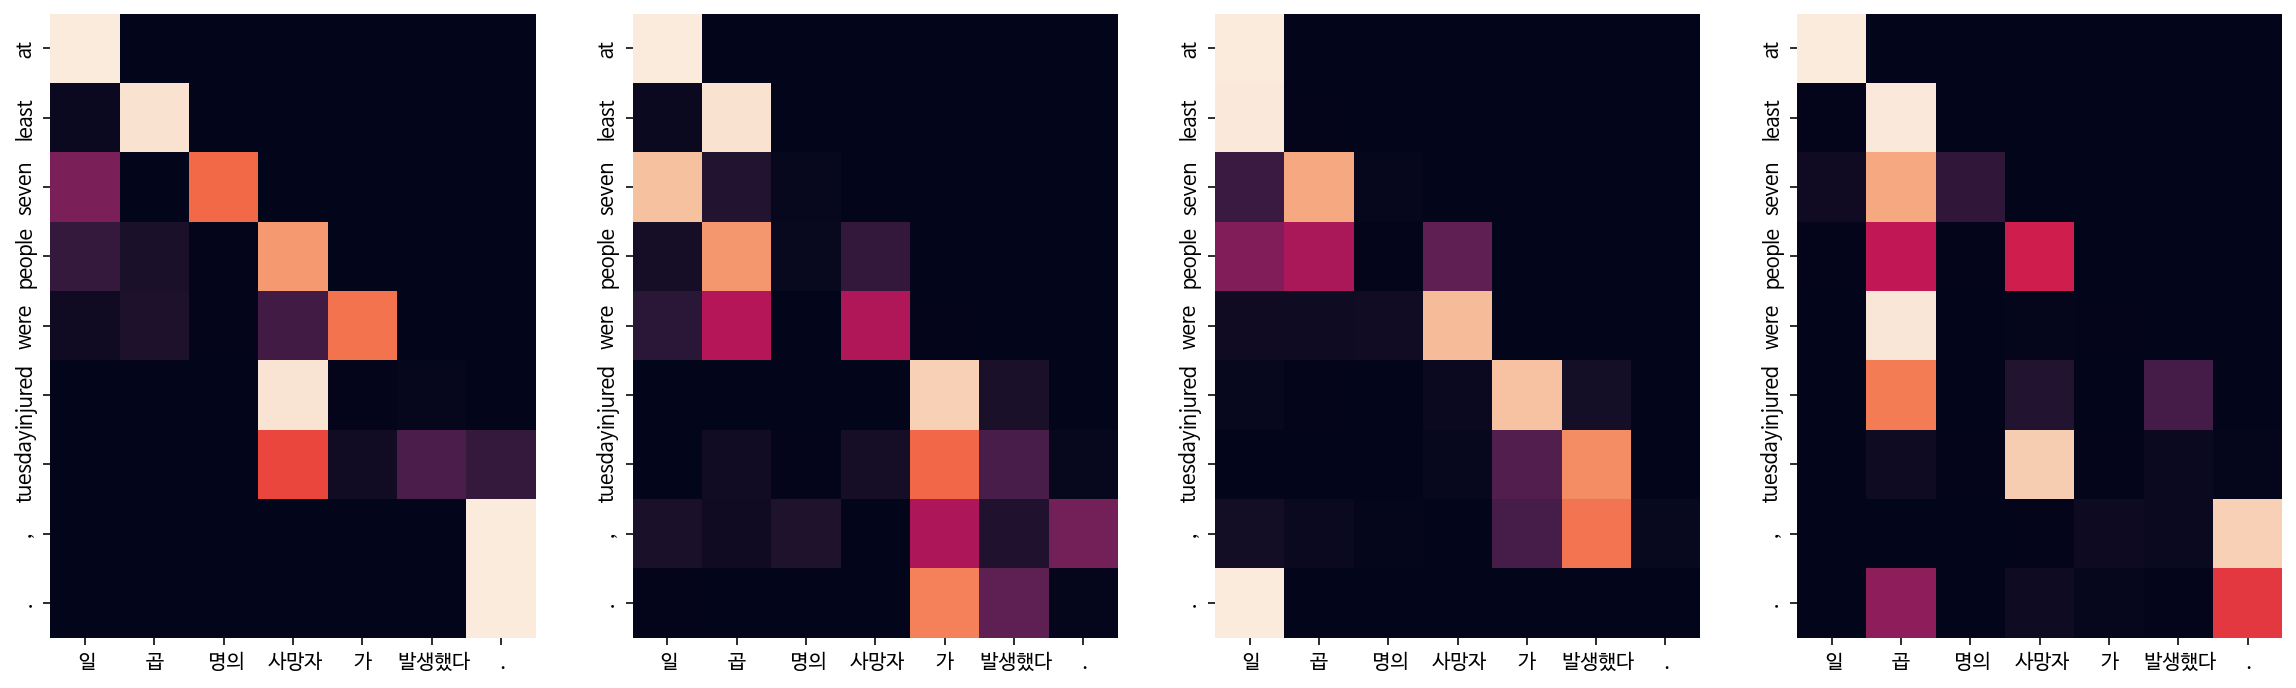

In [36]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer,plot_attention=1)

Input: 이집트에서 외교 공세를 펼치고 있는 세르게이 라브로프 러시아 외무장관이 24일(현지시간) 아랍연맹 회원국 대사들과의 만남에서 러시아가 세계 식량 위기를 초래했다는 주장을 일축했다.
Predicted translation: egypt s policy of emergency meeting between new york and russia , has hold an russia , citing political leaders , including russia s world food minister , and other russia in the region .
Encoder Layer 1


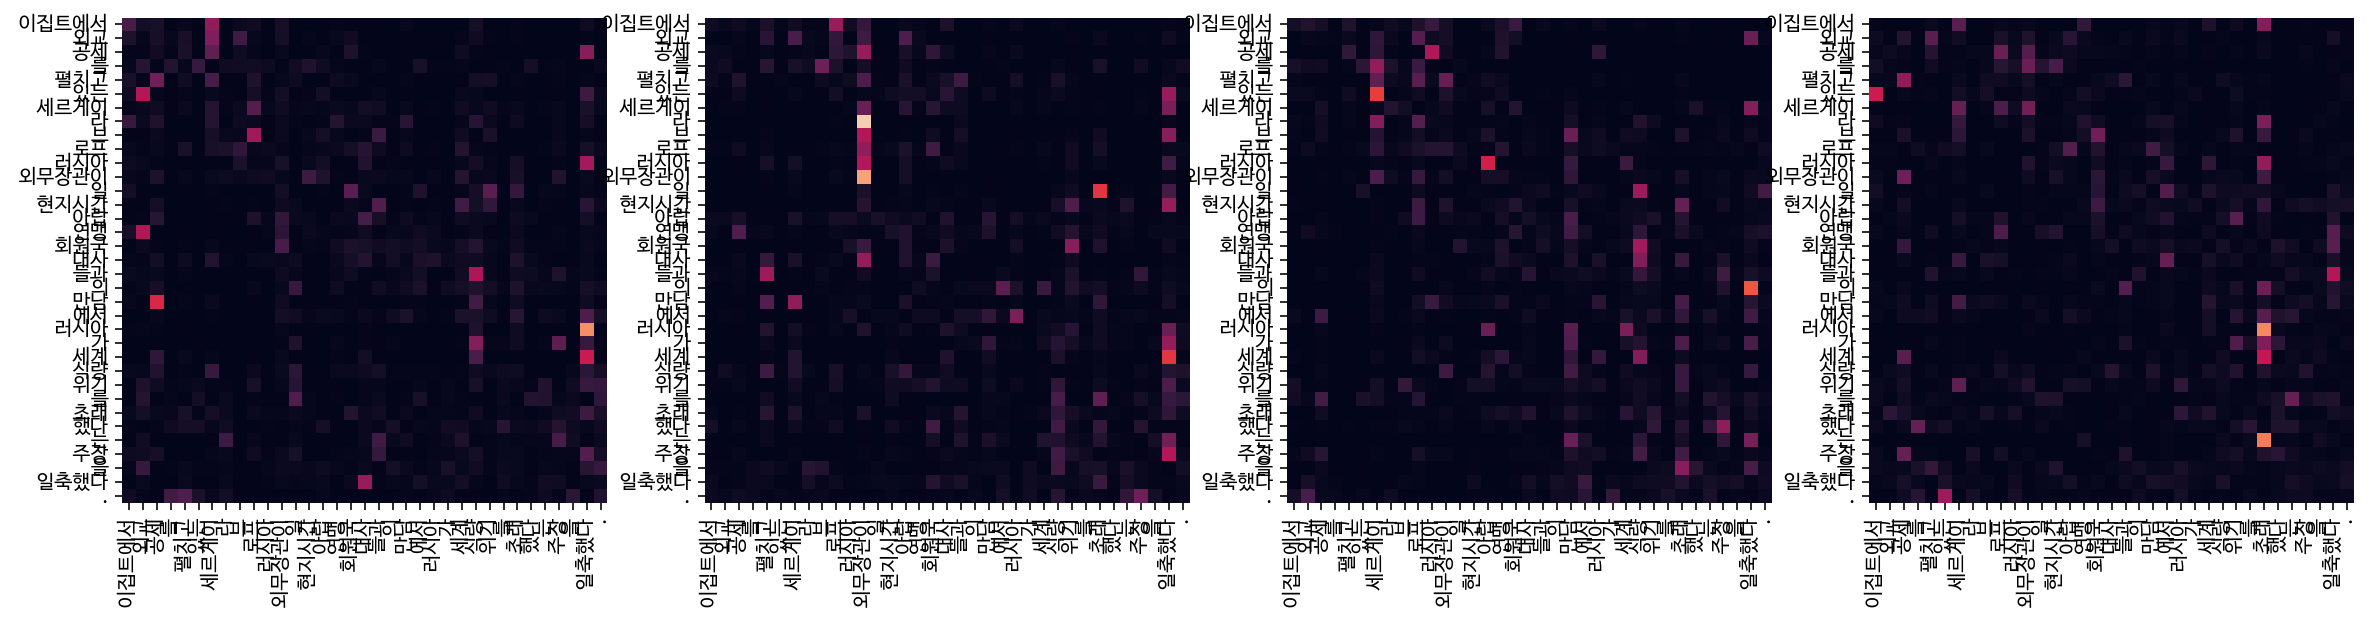

Encoder Layer 2


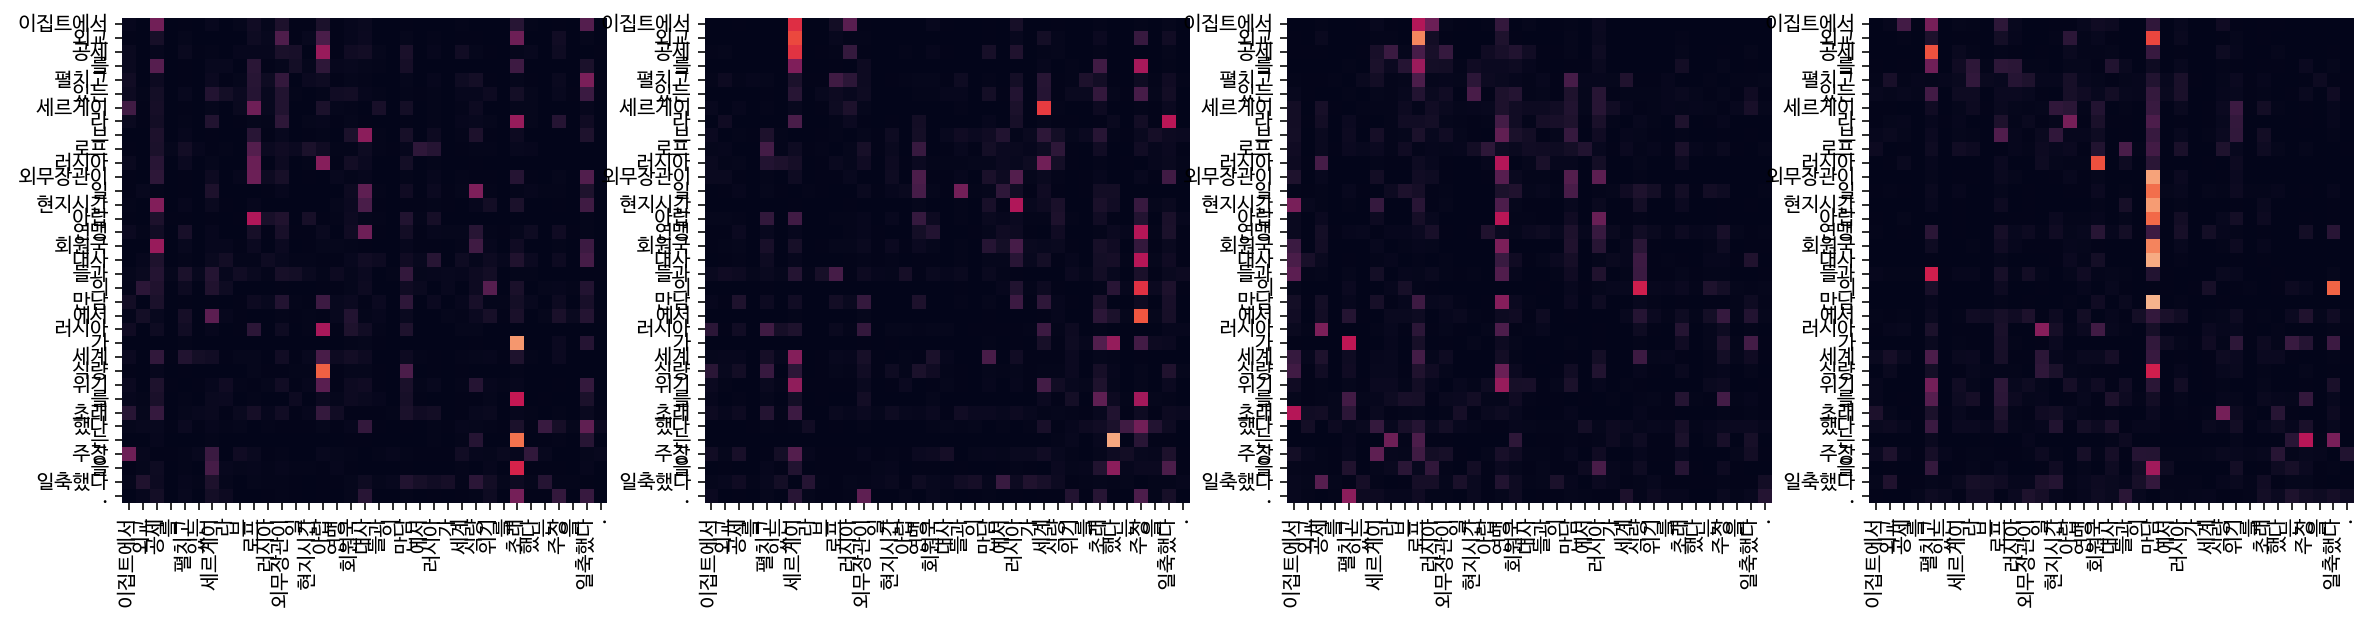

Decoder Self Layer 1


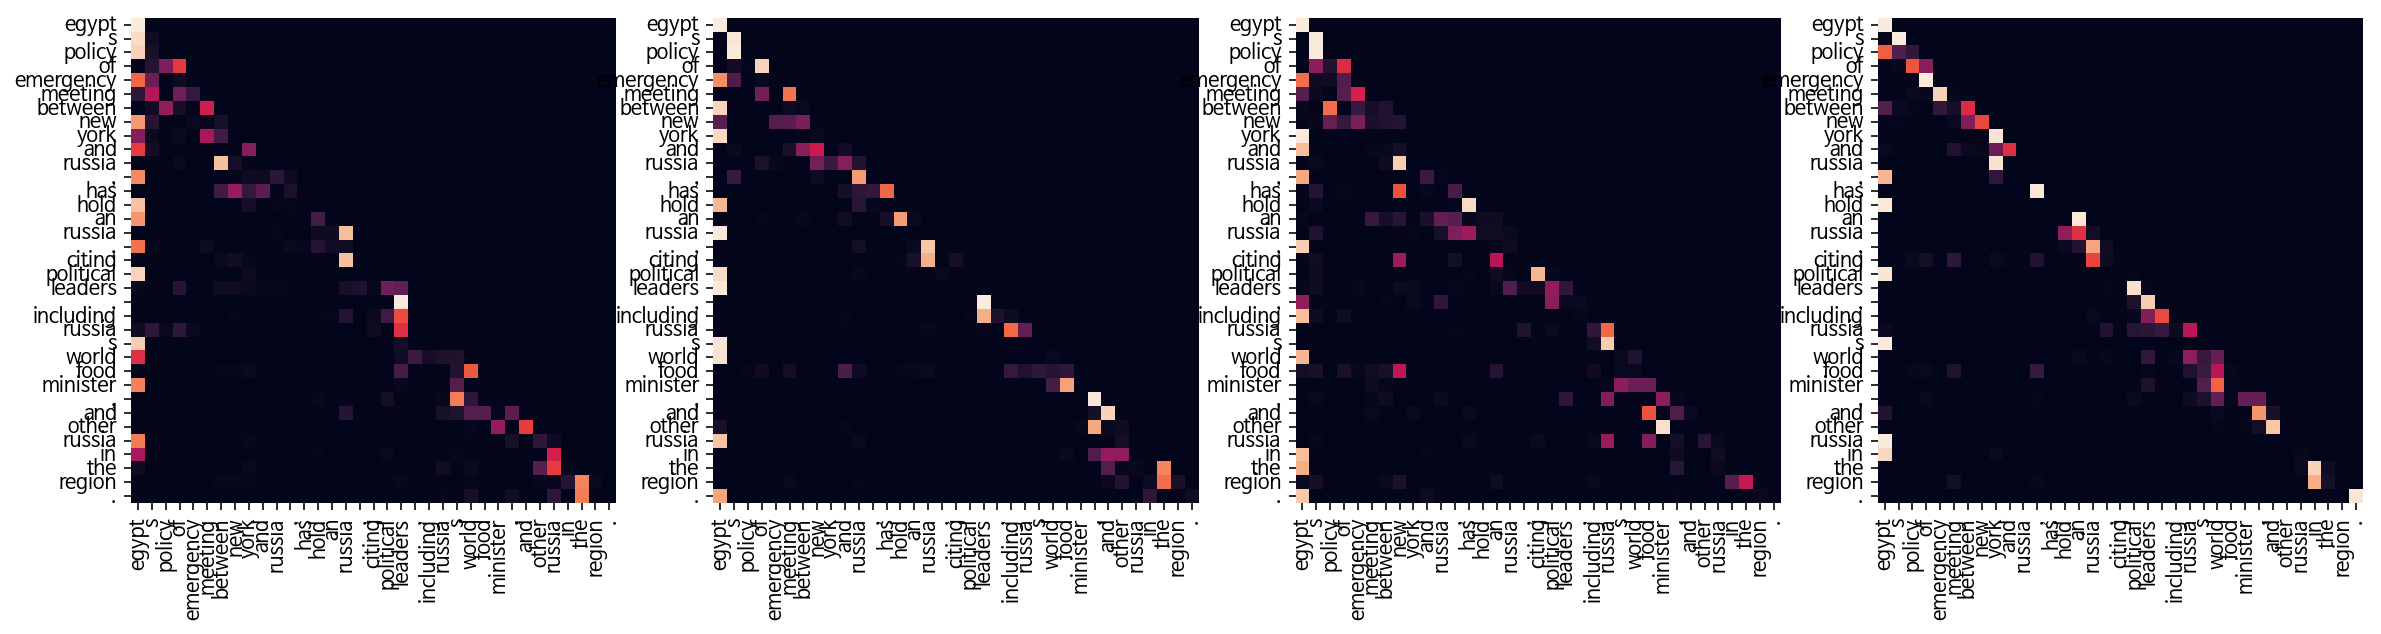

Decoder Src Layer 1


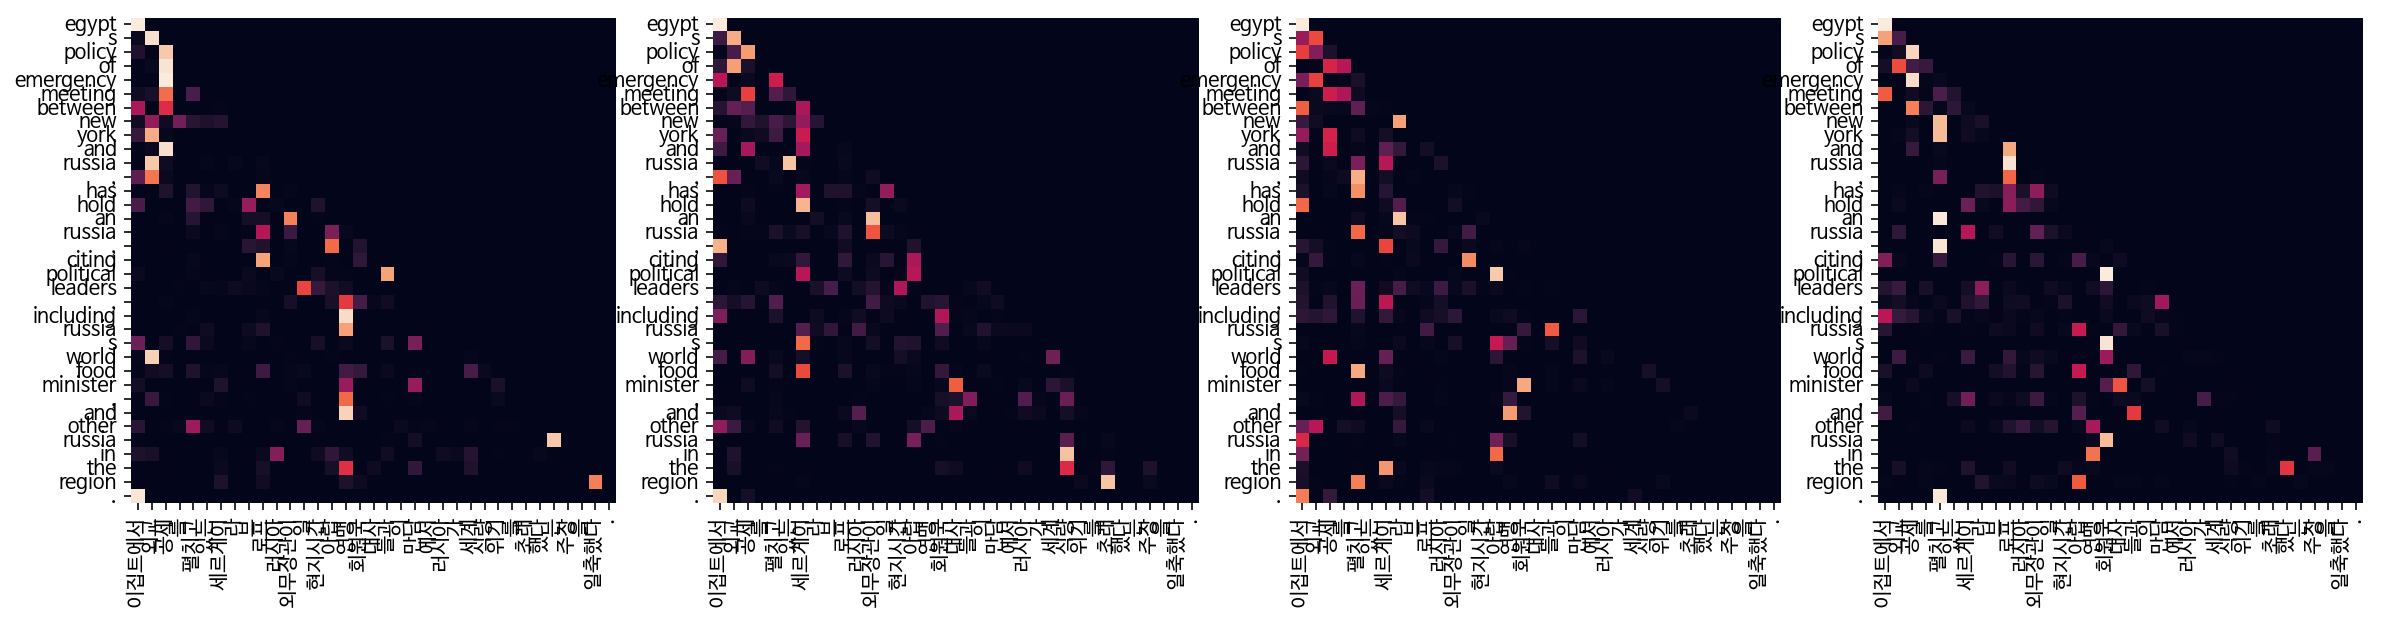

Decoder Self Layer 2


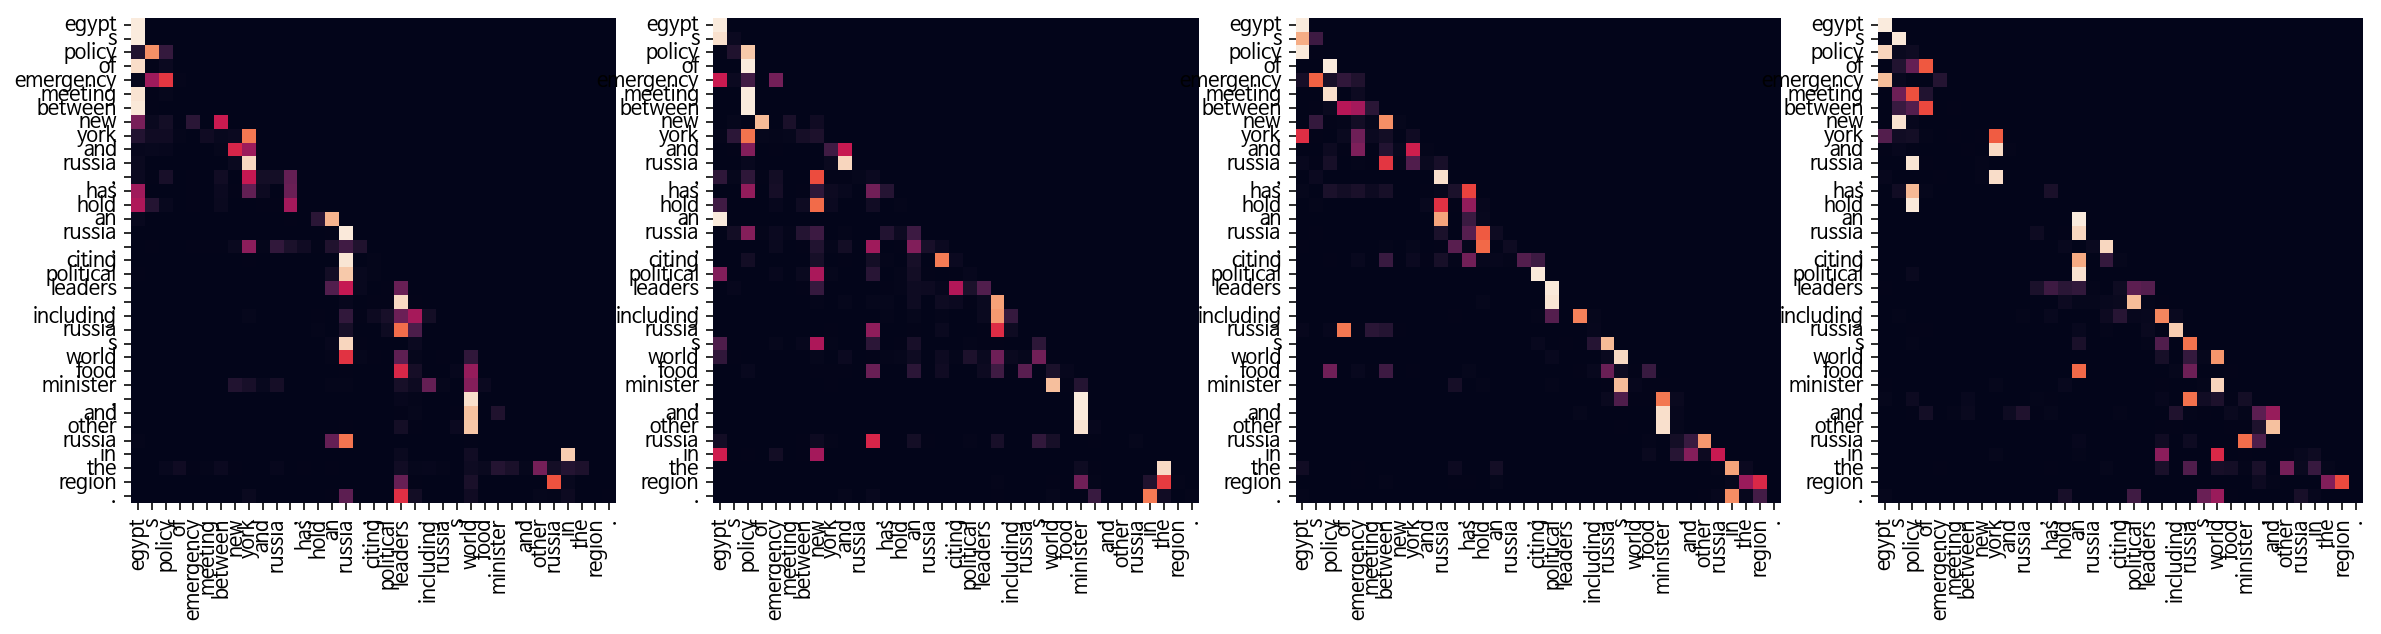

Decoder Src Layer 2


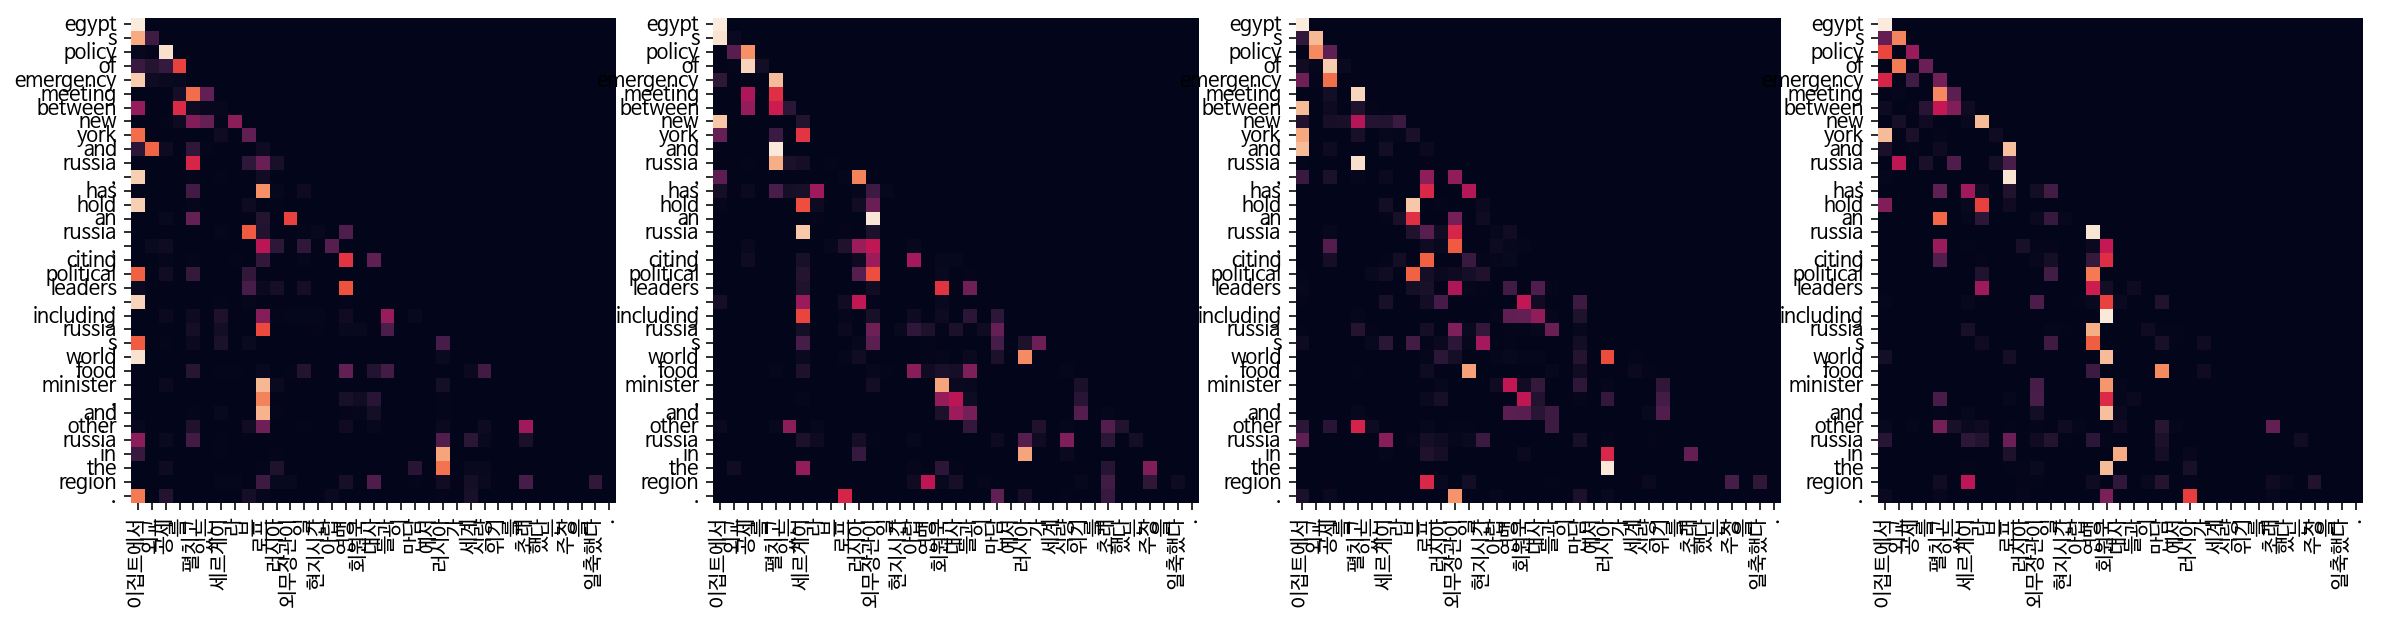

In [31]:
sen = '이집트에서 외교 공세를 펼치고 있는 세르게이 라브로프 러시아 외무장관이 24일(현지시간) 아랍연맹 회원국 대사들과의 만남에서 러시아가 세계 식량 위기를 초래했다는 주장을 일축했다.'
translate(sen, transformer, ko_tokenizer, en_tokenizer,plot_attention=1)
#파파고 역번역: 이집트는 세계식량장관을 포함한 정치지도자들과 그 지역의 다른 러시아를 인용하면서, 뉴욕과 러시아간의 긴급회의에 대한 정책을 개최하였다.

Input: 외국 용병들이 우크라이나에서 싸우는 이유
Predicted translation: germany s most dangerous ap firefighters reason to take some reason
Encoder Layer 1


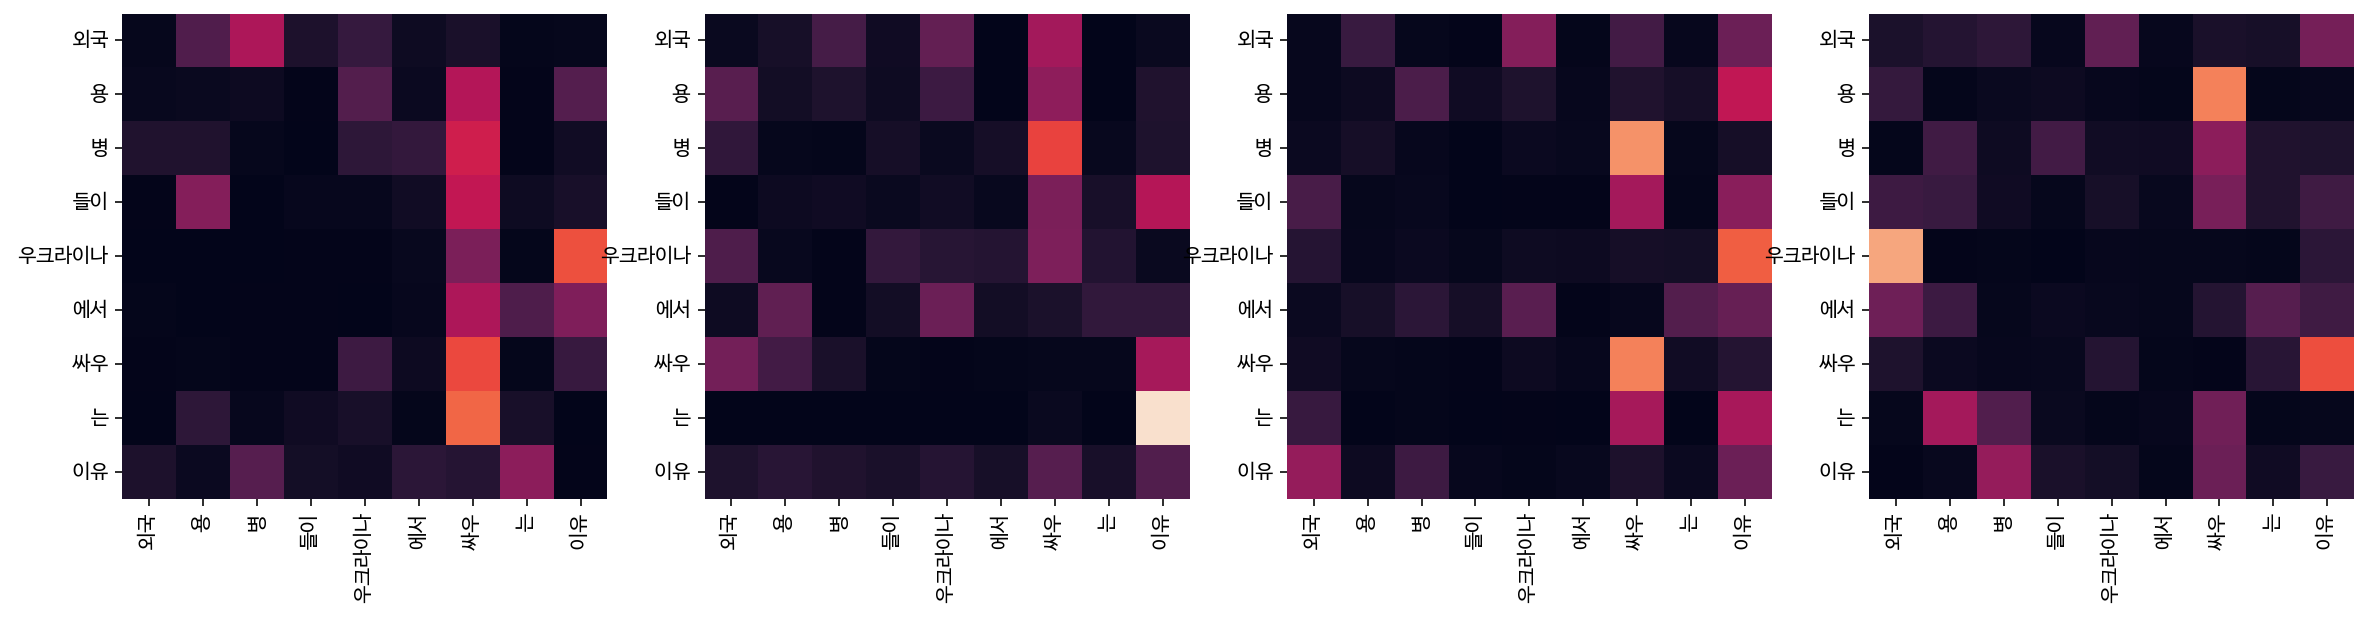

Encoder Layer 2


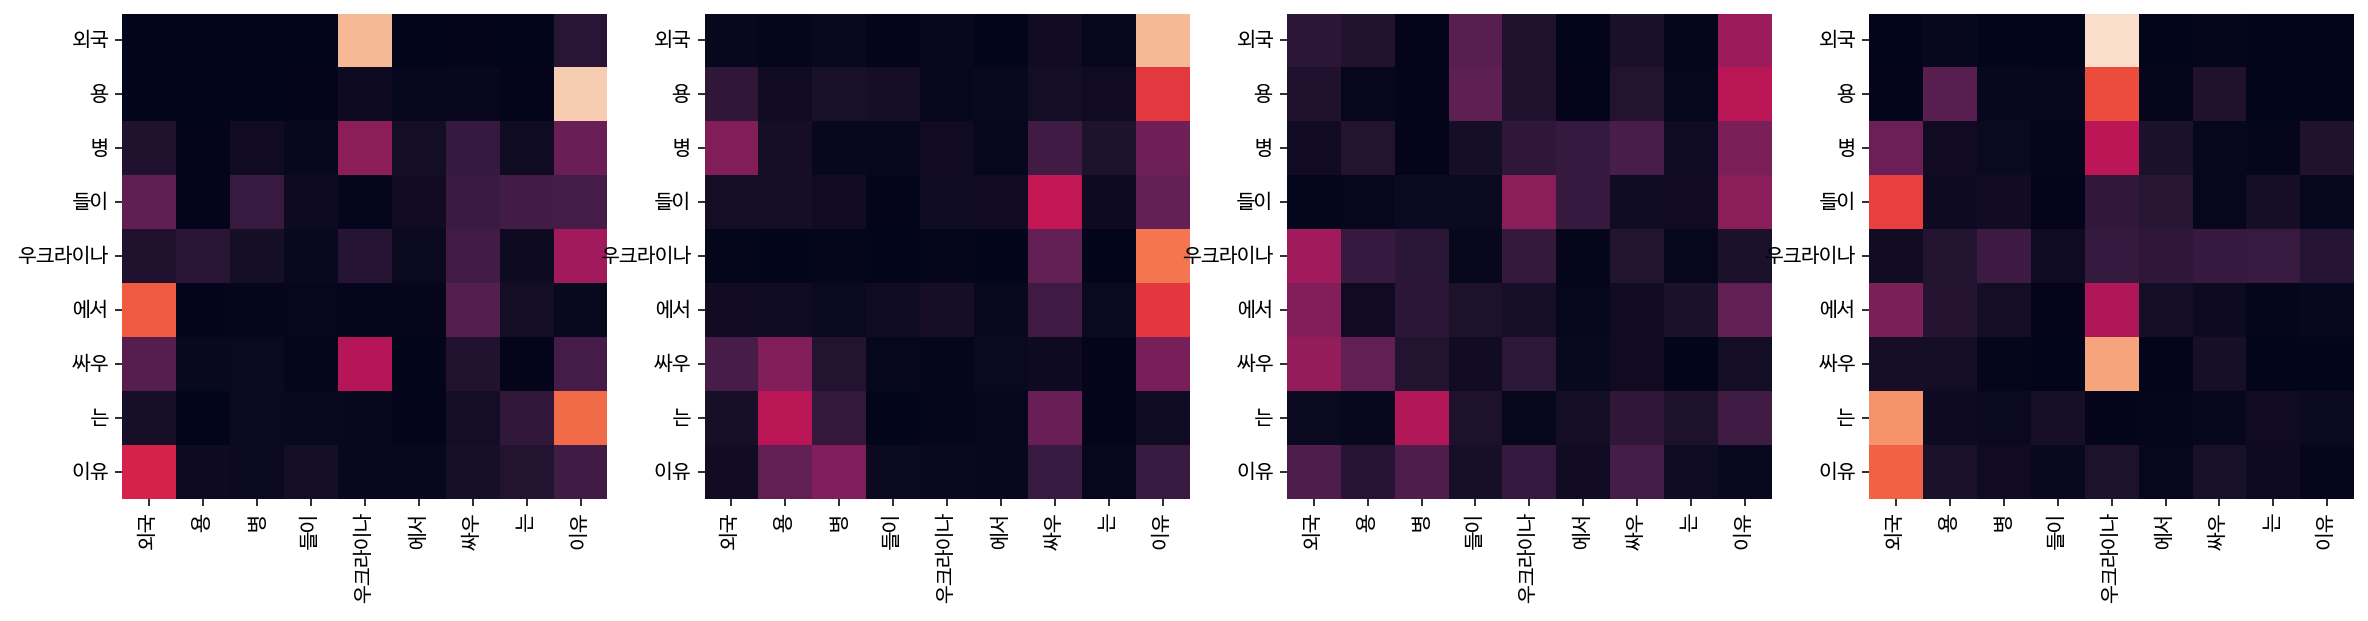

Decoder Self Layer 1


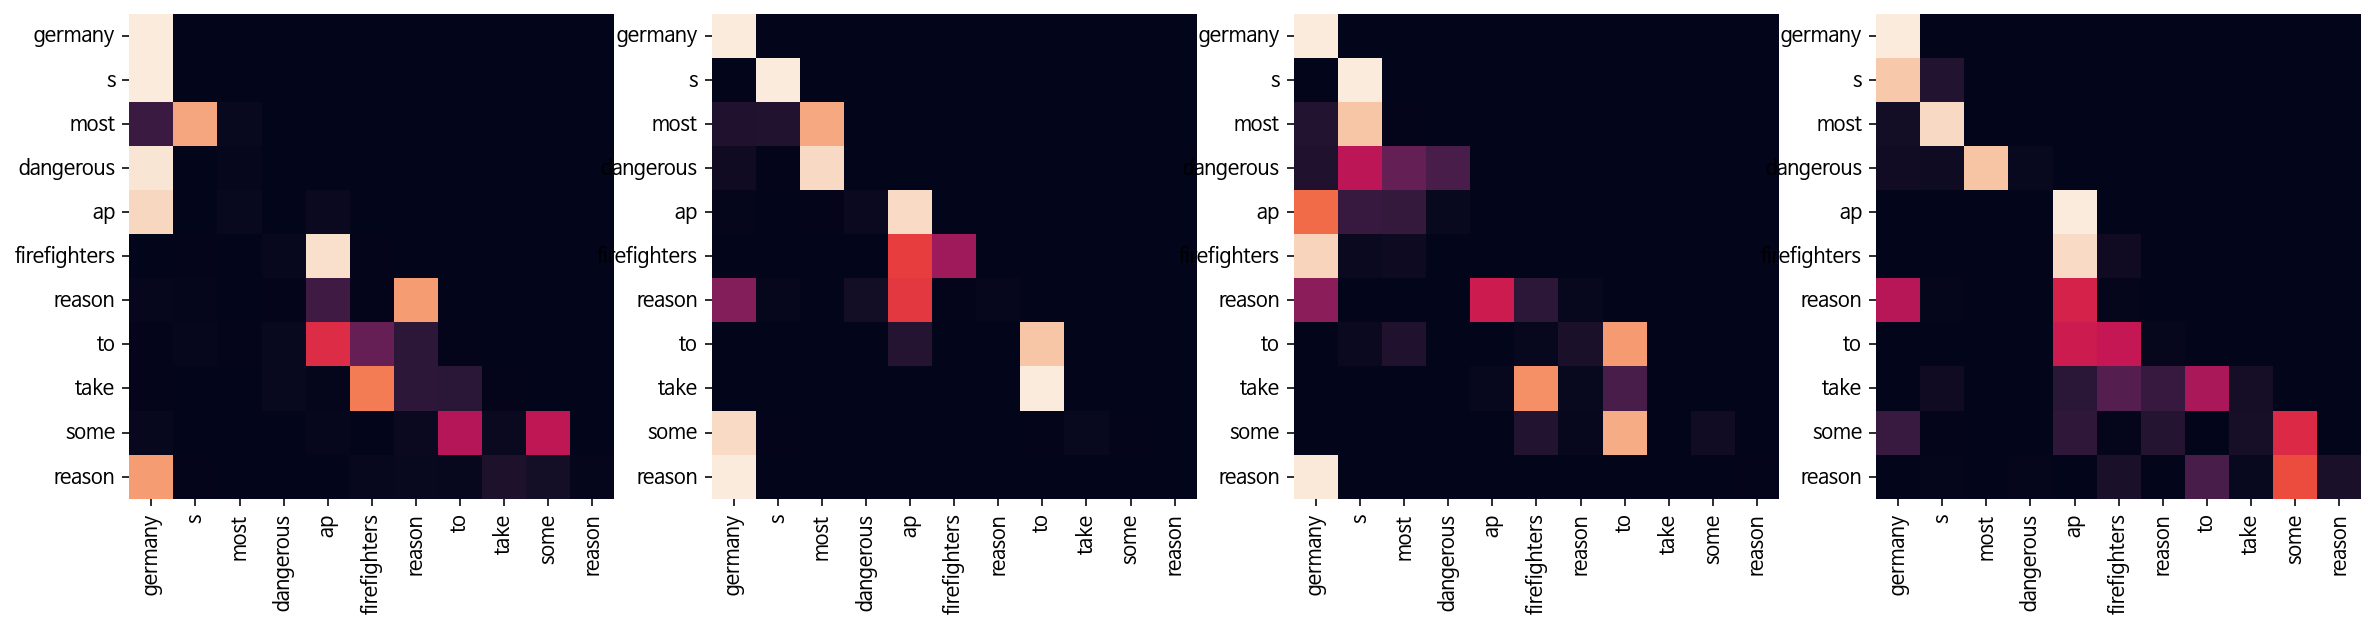

Decoder Src Layer 1


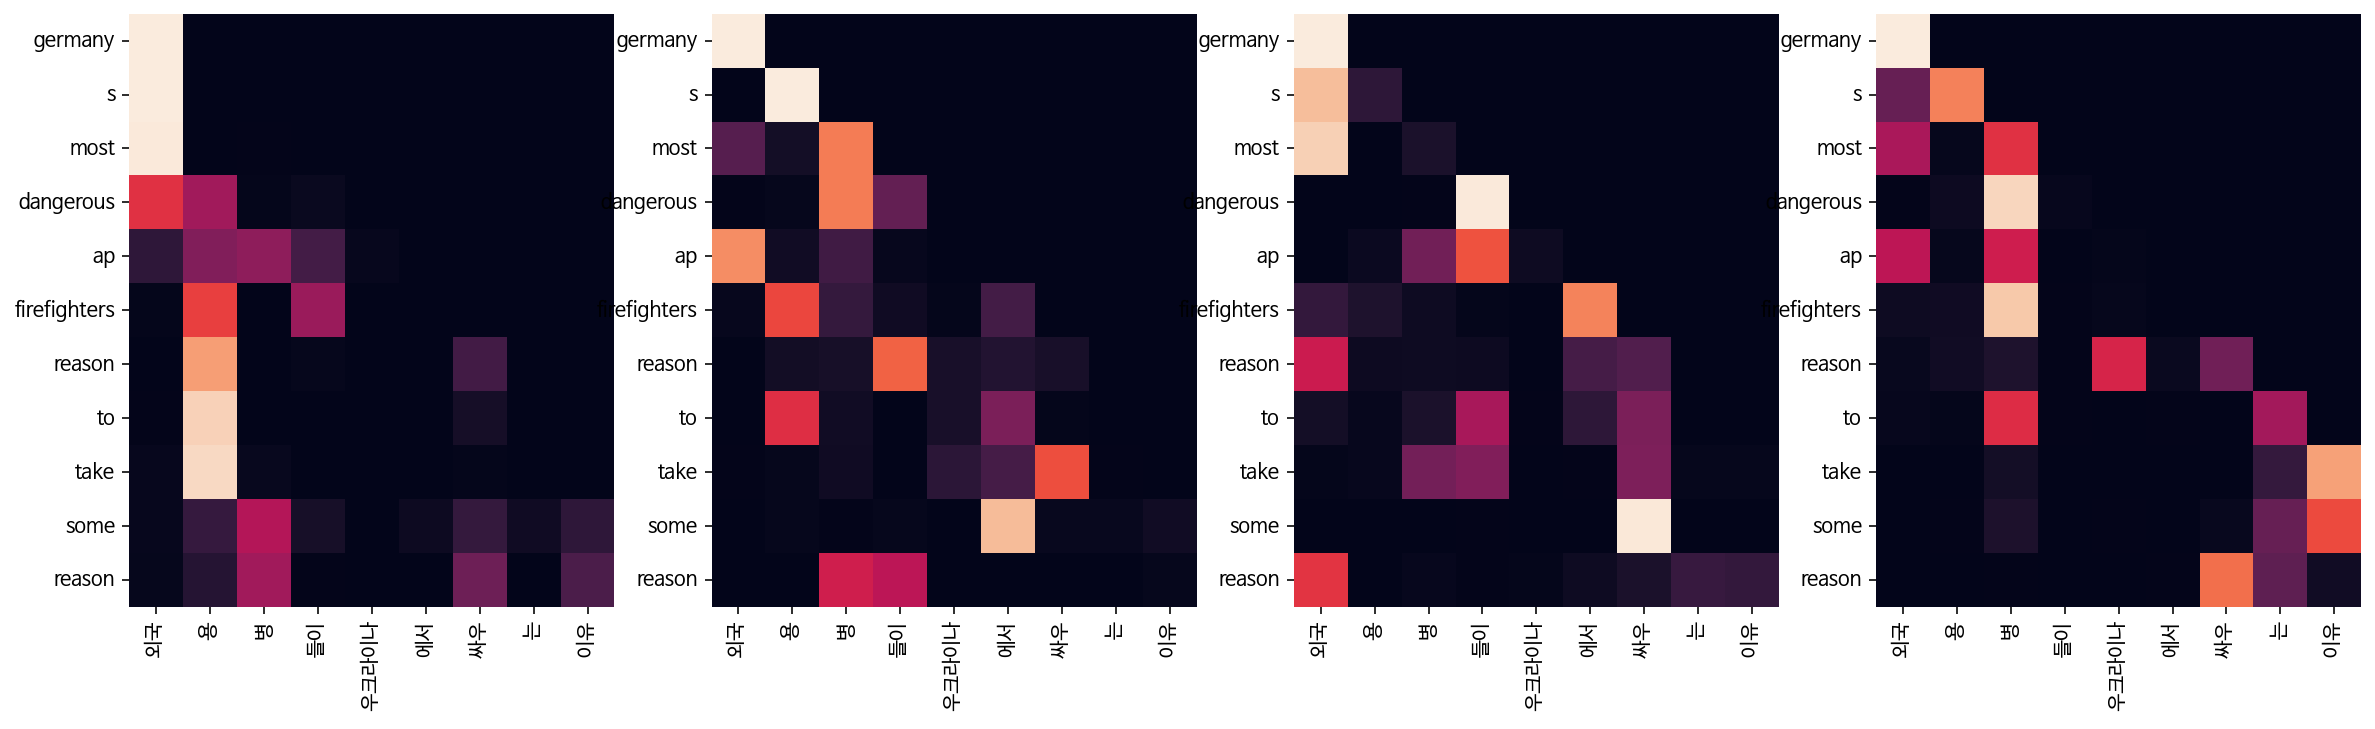

Decoder Self Layer 2


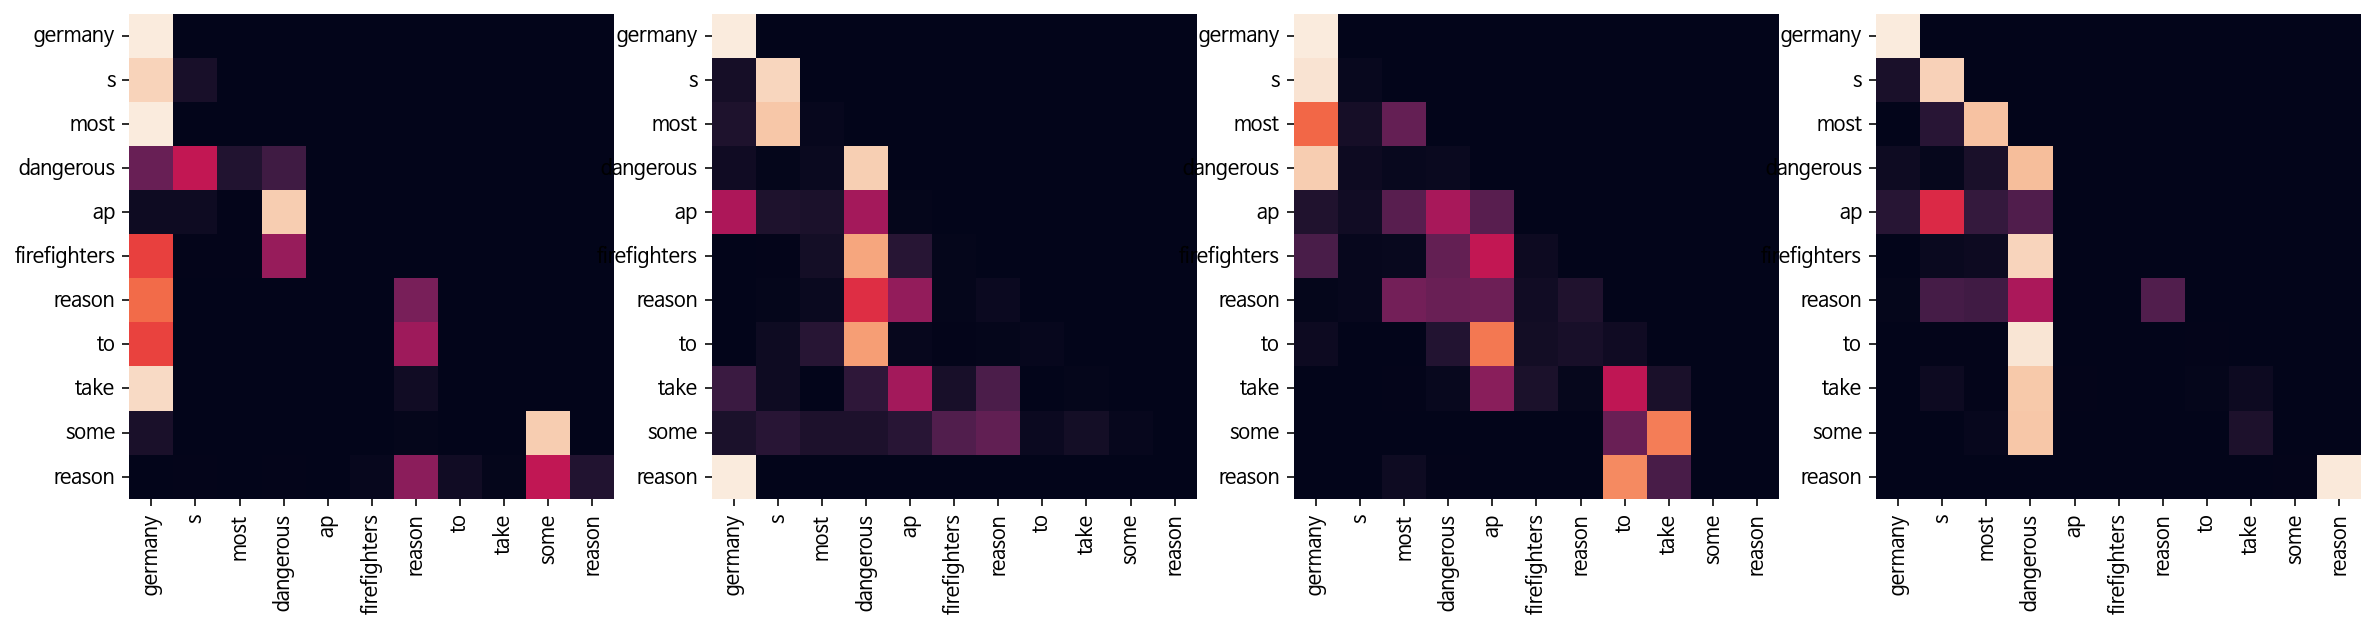

Decoder Src Layer 2


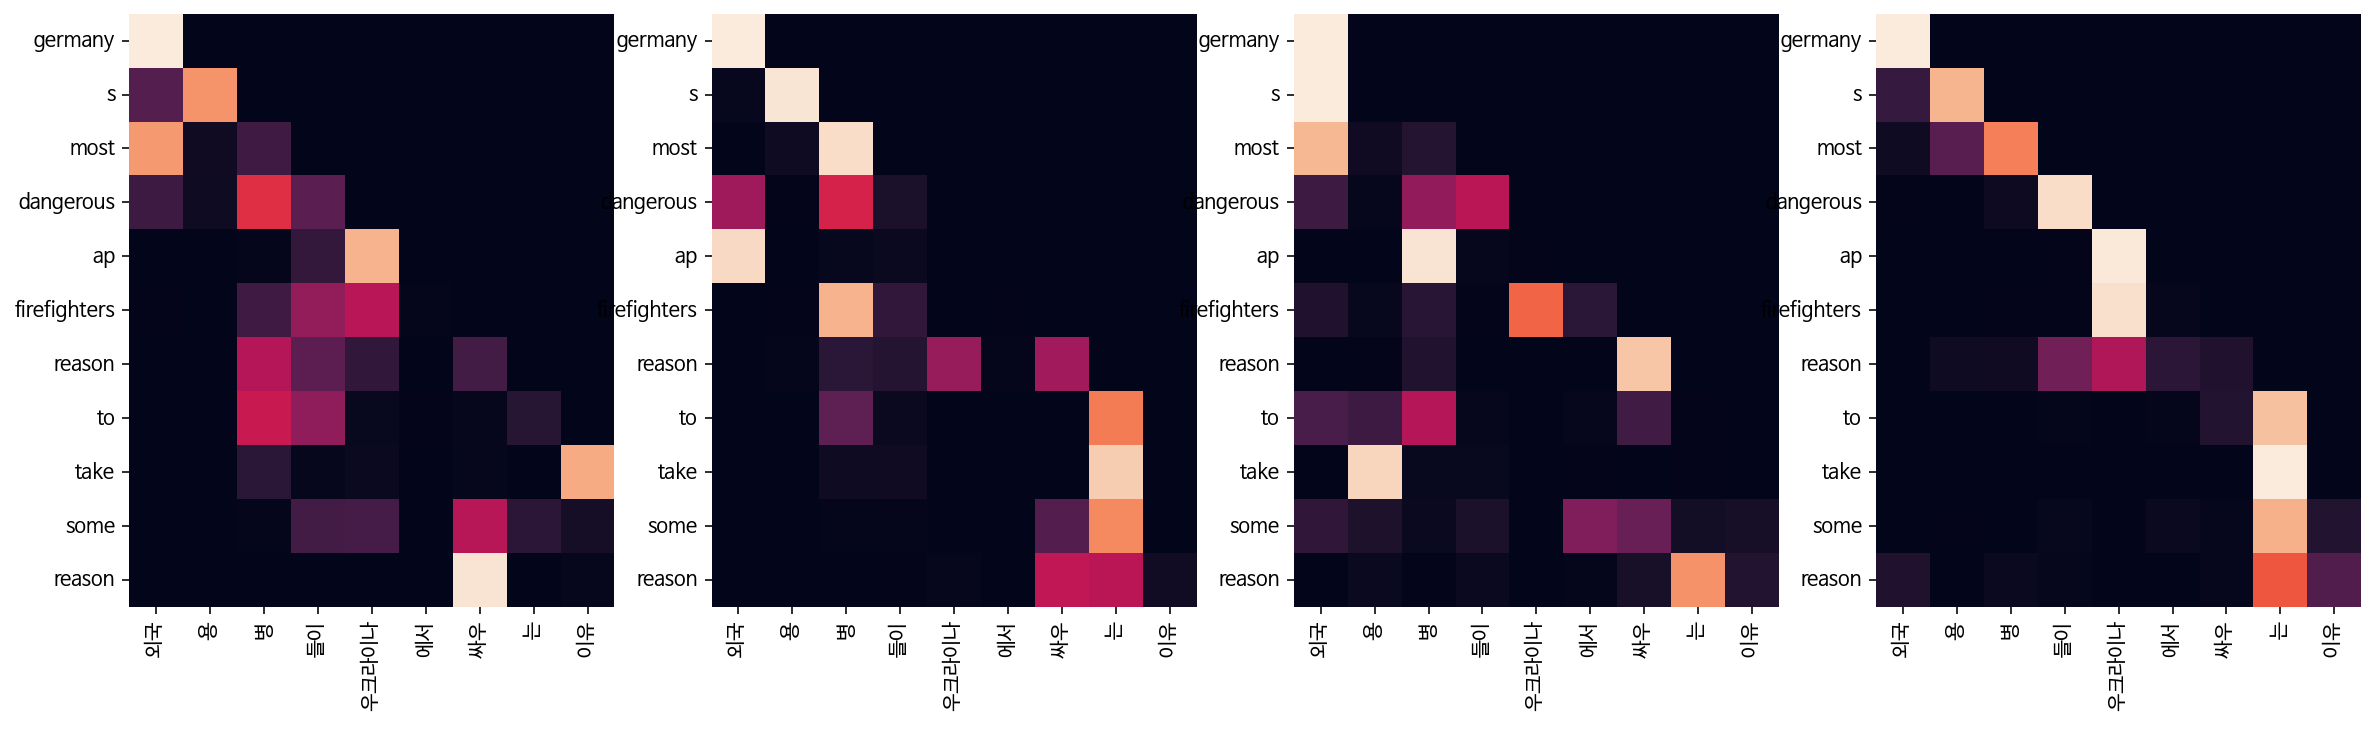

In [32]:
sen = '외국 용병들이 우크라이나에서 싸우는 이유'
translate(sen, transformer, ko_tokenizer, en_tokenizer,plot_attention=1)
#역번역 :독일의 가장 위험한 소방관들은 어떤 이유를 들려고 한다.

Input: 한편, 각국 중앙은행들이 정책금리 인상에 속도를 내면서 경기침체(recession)에 대한 우려도 커지고 있다. 
Predicted translation: in other interest rates , an easing of concerns about percent on the internet , the dollar has rise following the economic recovery of the inflation .
Encoder Layer 1


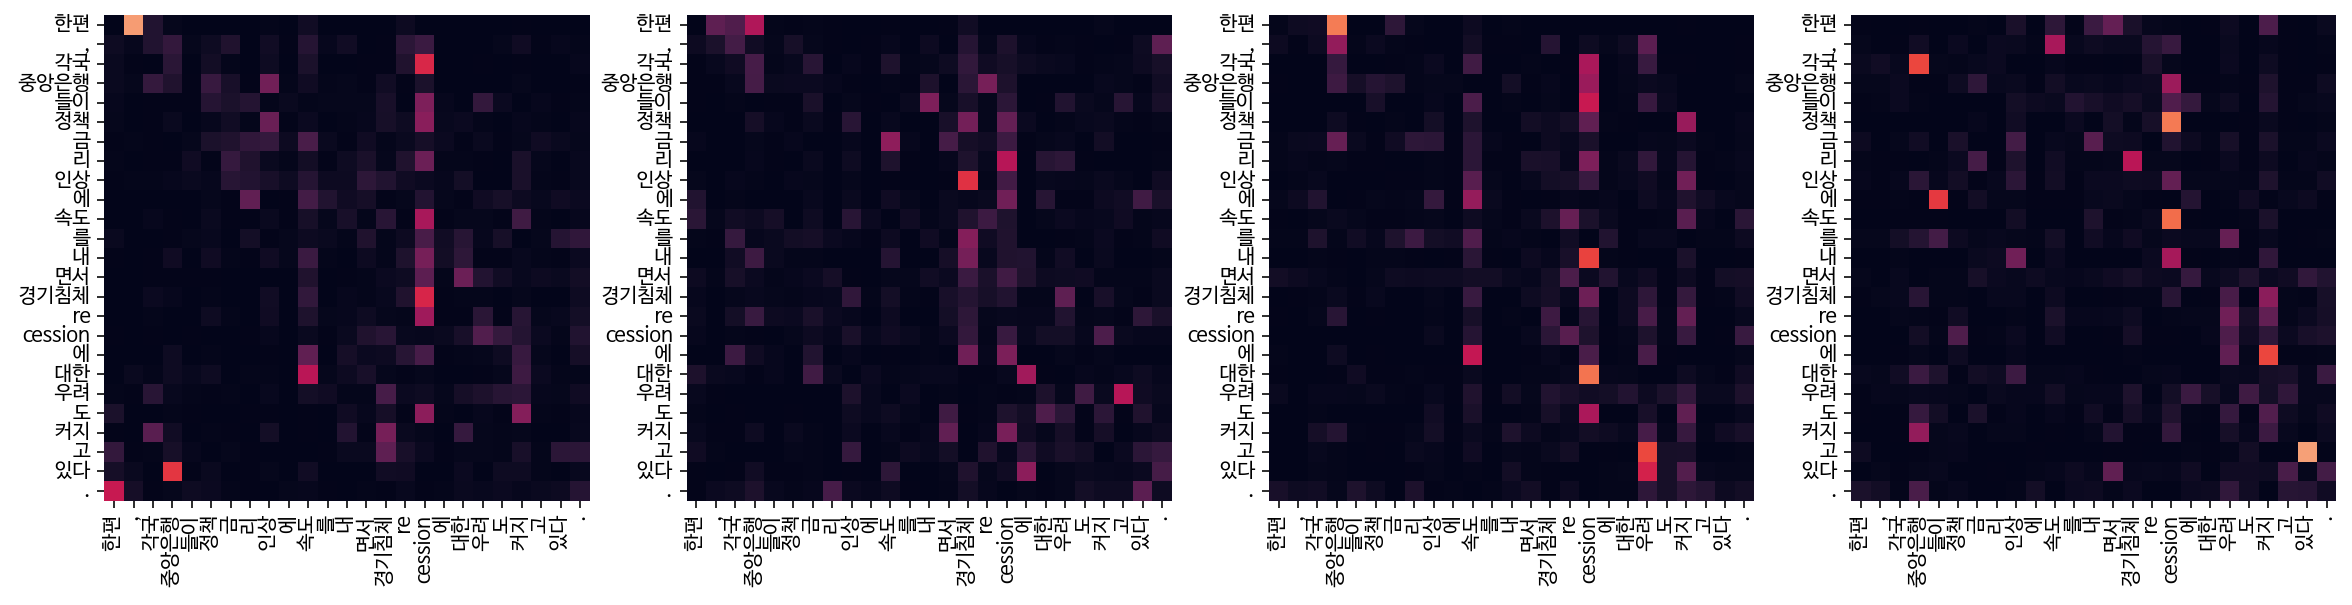

Encoder Layer 2


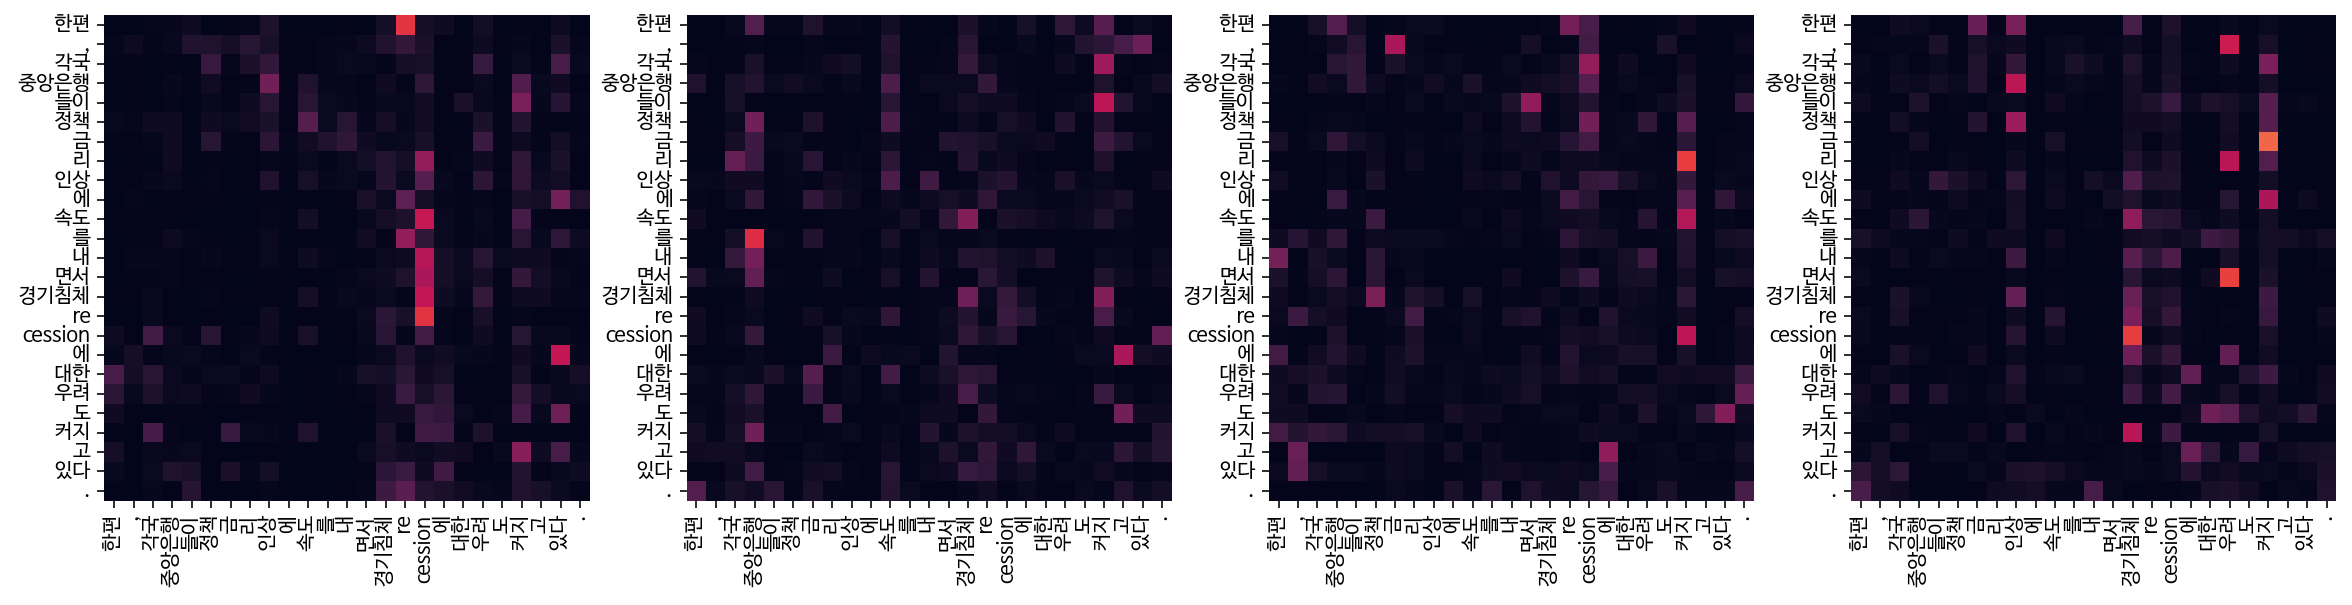

Decoder Self Layer 1


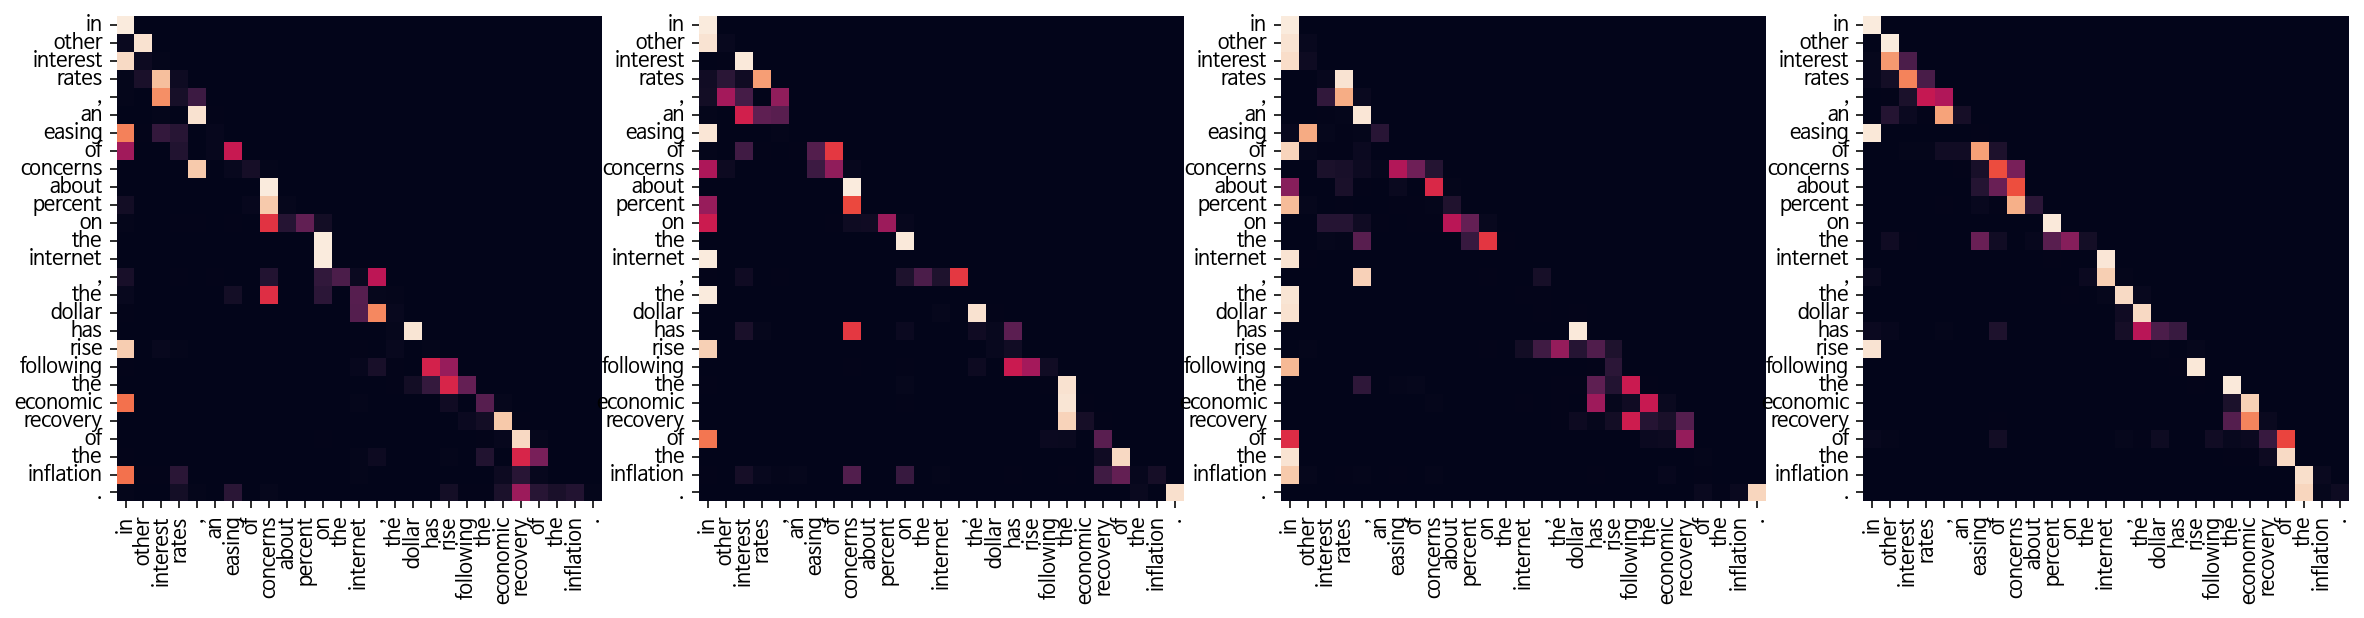

Decoder Src Layer 1


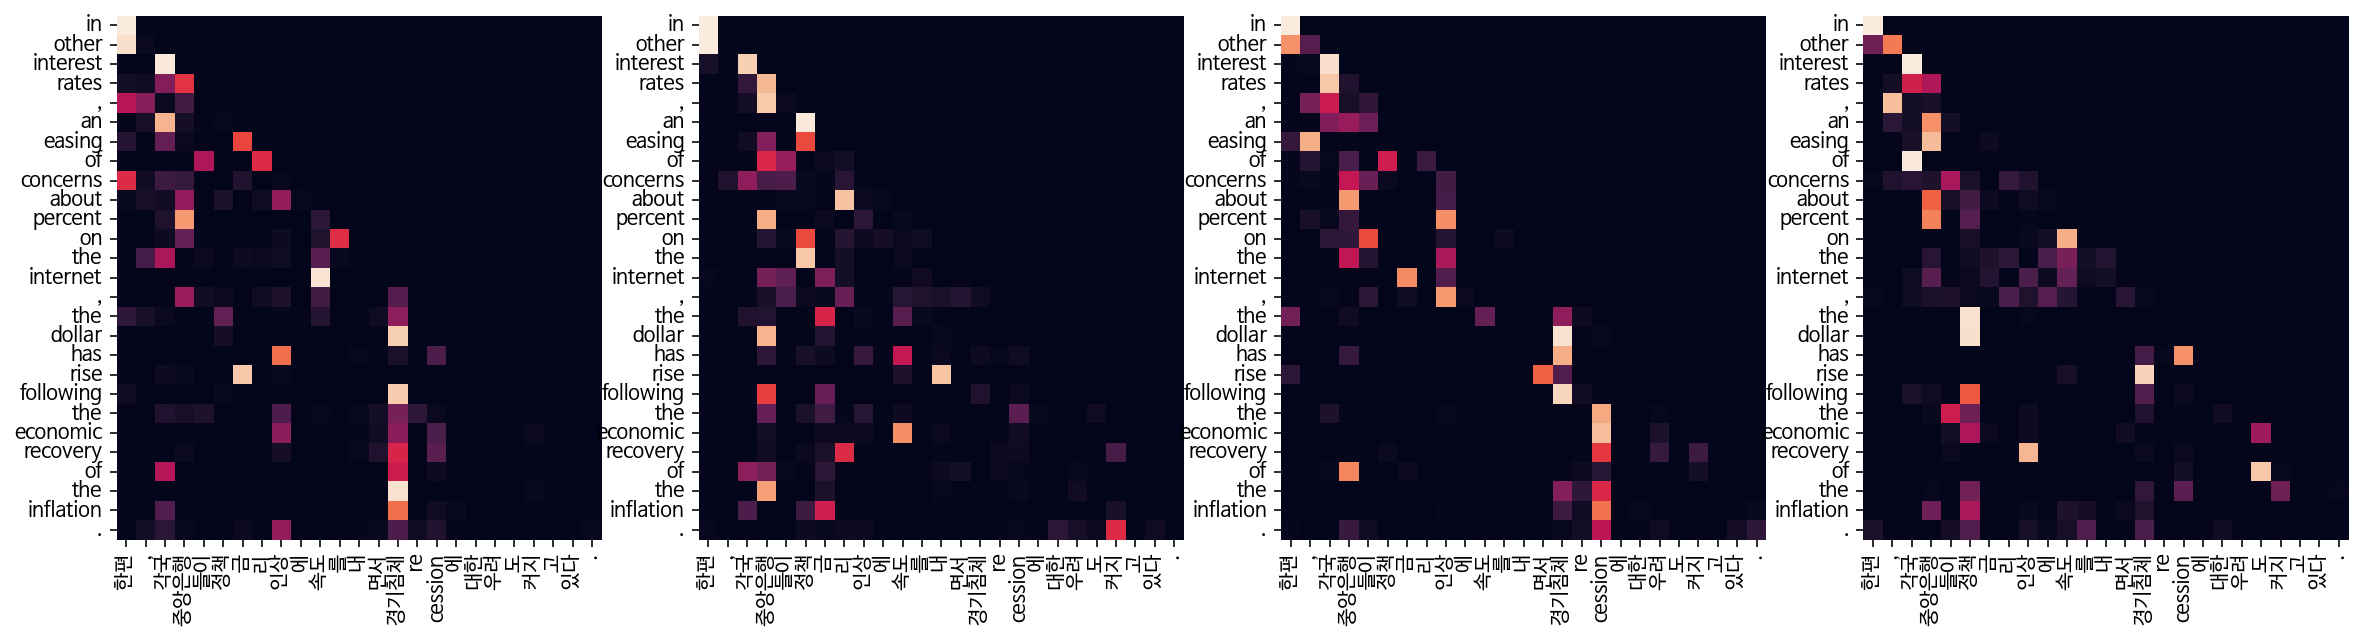

Decoder Self Layer 2


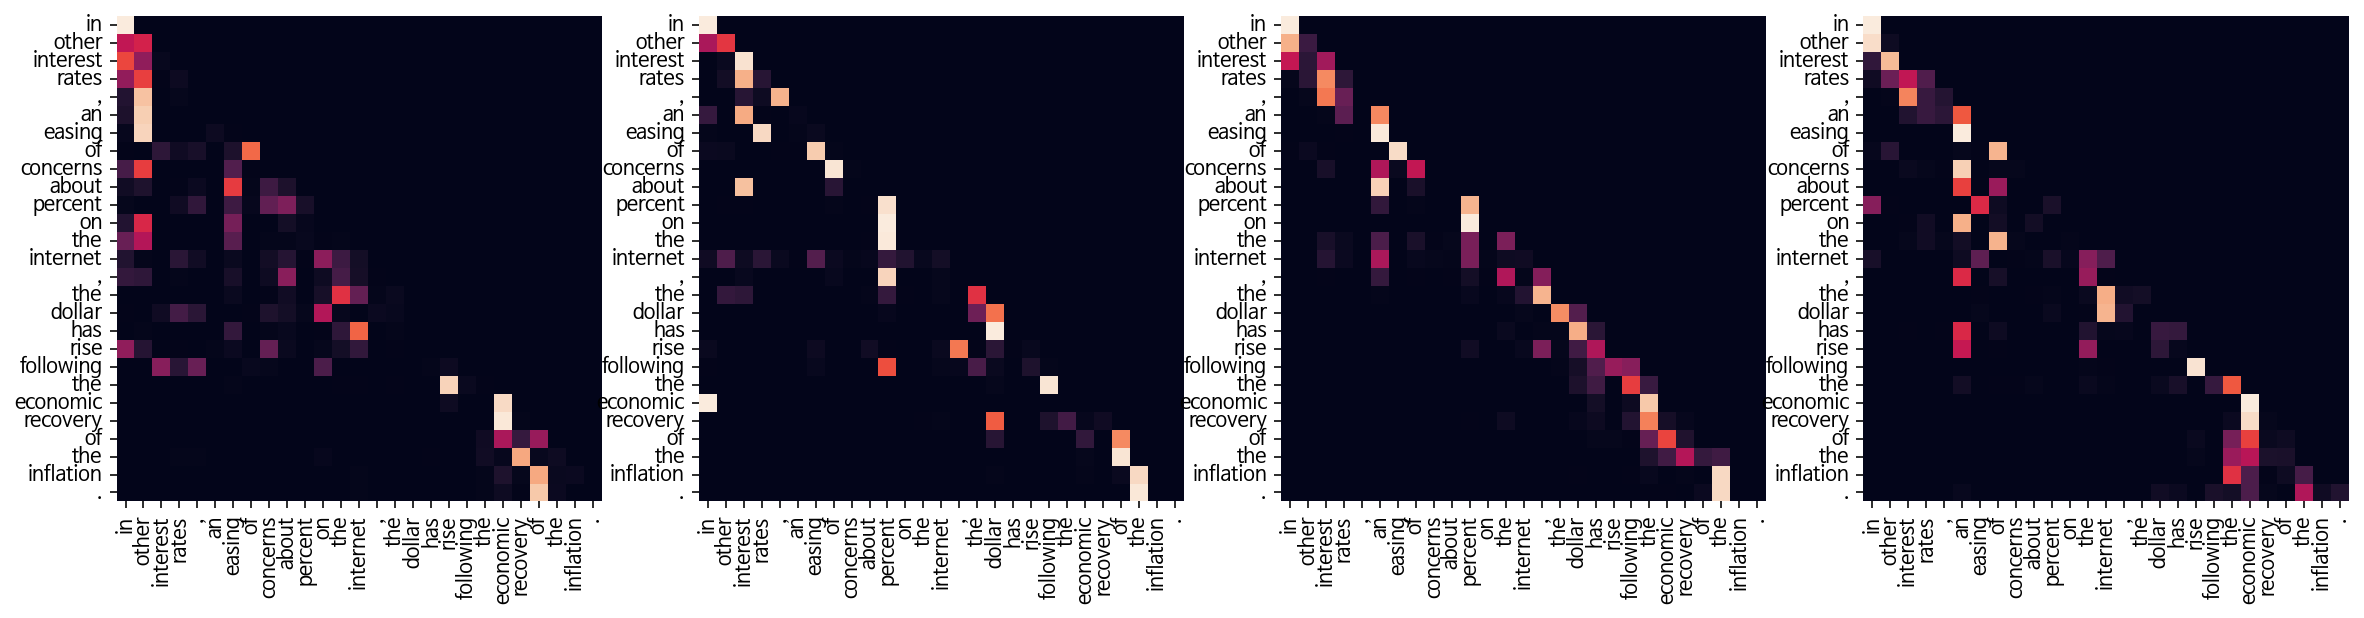

Decoder Src Layer 2


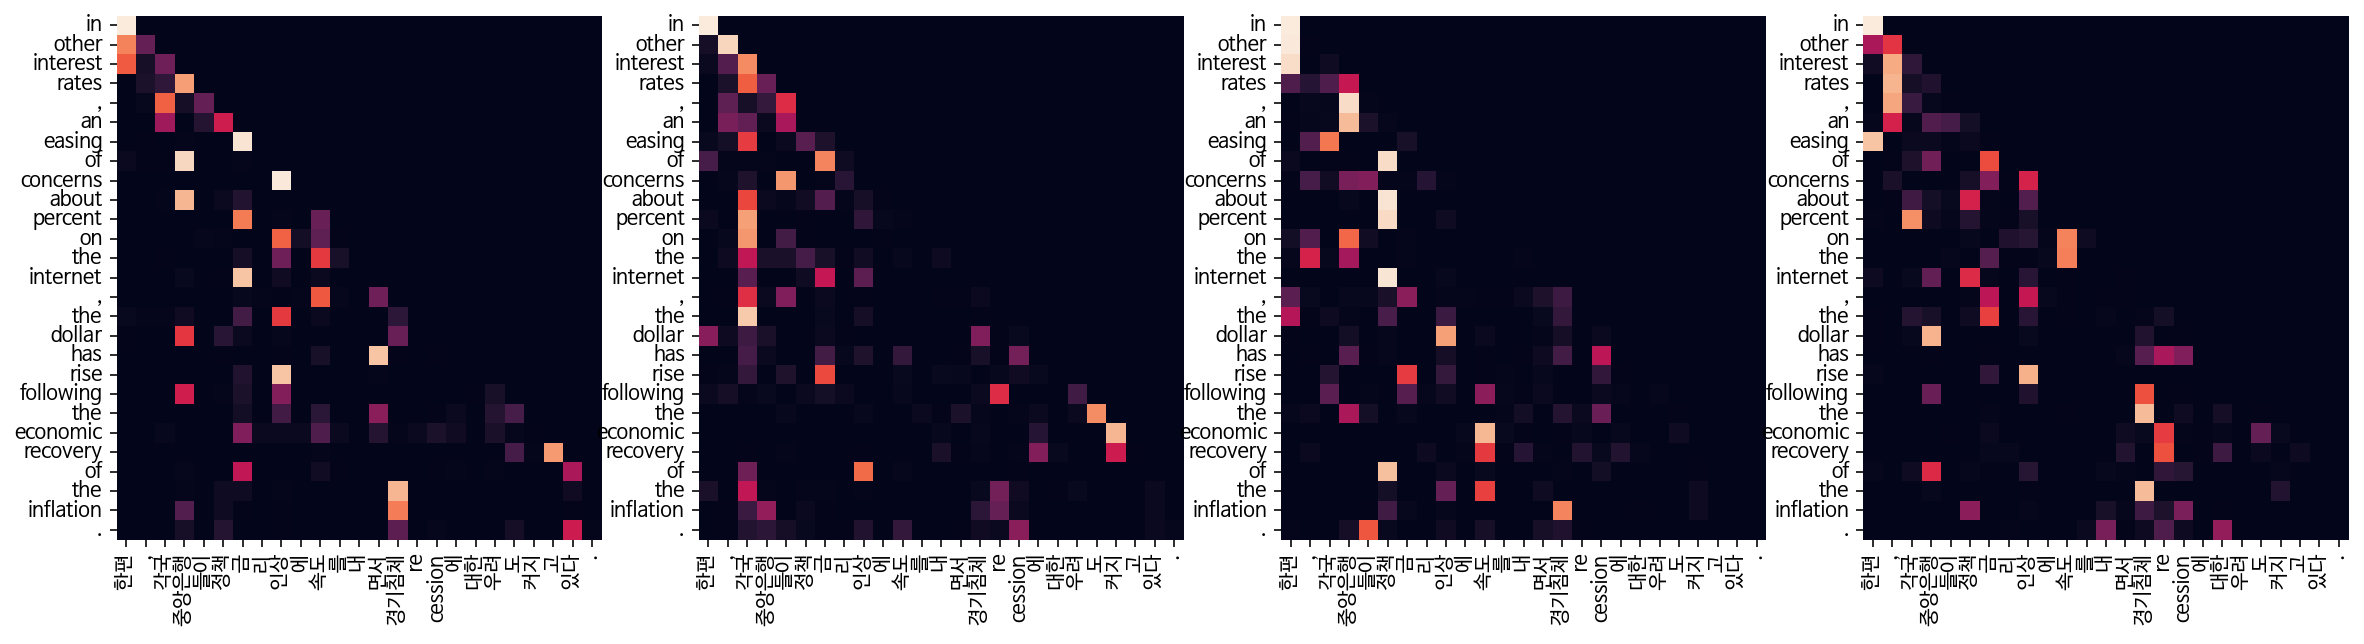

In [33]:
sen = '한편, 각국 중앙은행들이 정책금리 인상에 속도를 내면서 경기침체(recession)에 대한 우려도 커지고 있다. '
translate(sen, transformer, ko_tokenizer, en_tokenizer,plot_attention=1)
# 다른 이자율에서, 인터넷 상의 퍼센트에 대한 우려의 완화, 달러는 인플레이션의 경제적 회복에 따라 상승했다.

## 회고록
로스가 감소함에 따라서 첫문장이었던 '오바마는 대통령이다'의 번역이 오히려 망가졌던 경우도 있지만, 전반적으로 학습이 진행됨에 따라서 나은 번역을 내보이고 있는 것은 확인할 수 있었다. 다만 다른 예제 문장을 진행했을 때,  

원본문장 : '이집트에서 외교 공세를 펼치고 있는 세르게이 라브로프 러시아 외무장관이 24일(현지시간) 아랍연맹 회원국 대사들과의 만남에서 러시아가 세계 식량 위기를 초래했다는 주장을 일축했다.'  
파파고 역번역: 이집트는 세계식량장관을 포함한 정치지도자들과 그 지역의 다른 러시아를 인용하면서, 뉴욕과 러시아간의 긴급회의에 대한 정책을 개최하였다.  

원본문장 : '외국 용병들이 우크라이나에서 싸우는 이유'  
파파고 역번역 : 독일의 가장 위험한 소방관들은 어떤 이유를 들려고 한다.  

원본문장 : '한편, 각국 중앙은행들이 정책금리 인상에 속도를 내면서 경기침체(recession)에 대한 우려도 커지고 있다. '  
파파고 역변역 : 다른 이자율에서, 인터넷 상의 퍼센트에 대한 우려의 완화, 달러는 인플레이션의 경제적 회복에 따라 상승했다.  

일부 핵심단어들이 포함된 문장이 완성되었지만, 전반적으로 아직 부족한 성능을 보이고 있다.